# Deep Solaris Notebook for Automatic Filtering of NRW Dop20 data

OWSLIB is a library that allows to deal with WMS protocol <br>
In this notebook I basically download a map in TIFF format <br>
as an example on how to use it. <br>

The map will then be split and passed through a neural network for binning.


In [2]:
from owslib.wms import WebMapService

wms = WebMapService('https://www.wms.nrw.de/geobasis/wms_nw_dop', version='1.1.1')


In [12]:
print(list(wms.contents))

print(wms['nw_dop_rgb'].boundingBox)
print( wms['nw_dop_rgb'].styles)
print(wms['nw_dop_rgb'].boundingBoxWGS84)
print( wms['nw_dop_rgb'].crsOptions)

#EPSG:4326 is the one we want because it is a gps system.


['WMS_NW_DOP', 'nw_dop_utm_info', 'nw_dop_rgb', 'nw_dop_cir', 'nw_dop_nir']
(270100.0, 5550000.0, 550000.0, 5850000.0, 'EPSG:25832')
{'default': {'title': 'default', 'legend': 'https://www.wms.nrw.de/geobasis/wms_nw_dop?request=GetLegendGraphic&format=image/png&layer=keine_legende'}}
(5.59334, 50.0578, 9.74158, 52.7998)
['EPSG:3043', 'EPSG:5652', 'EPSG:28992', 'EPSG:5649', 'EPSG:5653', 'EPSG:3044', 'EPSG:4258', 'EPSG:25831', 'EPSG:5651', 'EPSG:31466', 'EPSG:4326', 'EPSG:3045', 'EPSG:3857', 'EPSG:5650', 'EPSG:31467', 'EPSG:4647', 'EPSG:3034', 'EPSG:25832', 'EPSG:25833', 'EPSG:3035']


In [6]:
print([op.name for op in wms.operations])
print(wms.getOperationByName('GetMap').methods)
print(wms.getOperationByName('GetMap').formatOptions)


['WMS_NW_DOP', 'nw_dop_utm_info', 'nw_dop_rgb', 'nw_dop_cir', 'nw_dop_nir']
['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'DescribeLayer', 'GetLegendGraphic', 'GetStyles']
[{'type': 'Get', 'url': 'https://www.wms.nrw.de/geobasis/wms_nw_dop?'}, {'type': 'Post', 'url': 'https://www.wms.nrw.de/geobasis/wms_nw_dop?'}]
['image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/tiff', 'application/vnd.google-earth.kml+xml', 'application/vnd.google-earth.kmz']


In [13]:
# this prints the whole NRW in a 300, 250 image, just to see that we are in the right place.
img = wms.getmap(   layers=['nw_dop_rgb'], styles=['default'], srs='EPSG:4326',
                bbox=(5.59334, 50.0578, 9.74158, 52.7998), 
                 size=(300, 250), format='image/jpeg', transparent=True)


In [ ]:
#plt.imshow(img.read())
#plt.show()

out = open('attempt2.jpg', 'wb')
out.write(img.read())
out.close()

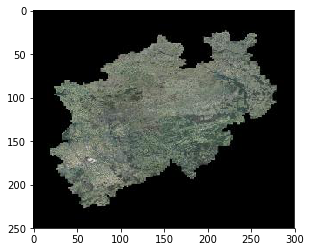

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgl=mpimg.imread('attempt2.jpg')
imgplot = plt.imshow(imgl)

plt.show() #there you go.

# Interesting longitudes and latitudes for the project

Bonn: bonn_center=(7.0982, 50.7374) <BR>
Essen:  essen_center=(7.0116, 51.4556) <BR>
Dortmund: dortmun_center=(7.4653,51.5136) <BR>
Duisburg: duisburg_center=(6.7623,51.4344) <BR>

simply use them below, by changing loc.

Below epsg:4326 allows to specify the GPS coordinates
while epsg:3857 allows to specify things in meters.


In [154]:
#now we center ourself on top of Aachen
from pyproj import Proj, transform


center= (7.046409,51.432946 )#(6.7623,51.4344) #(7.4653,51.5136)#(7.0116, 51.4556)#(6.0839,50.7753)

loc = center

outProj = Proj(init='epsg:3857') # https://epsg.io/3857, basically it allows me to specify things in meters..

inProj = Proj(init='epsg:4326') # https://epsg.io/4326

x, y = transform(inProj,outProj,loc[0],loc[1])

# in meters

x_meters = 1000
x_pixels = x_meters*5 #dop20 means 20cm per pixel, 100cm= 1m
y_meters= 1000
y_pixels = y_meters*5

region_size = (x_meters, y_meters) #just 20 meters around the city center to see what comes out.

xupper = int(round(x - region_size[0] / 2))
xlower = int(round(x + region_size[0] / 2))
yupper = int(round(y - region_size[1] / 2))
ylower = int(round(y + region_size[1] / 2))

bbox = (xupper, yupper, xlower, ylower)

#a very approximated 20x20 meters in 300 by 300 pixels...
img = wms.getmap(   layers=['nw_dop_rgb'], styles=['default'], srs='EPSG:3857',
                bbox=bbox, 
                 size=(x_pixels, y_pixels), format='image/tiff', transparent=True)

In [155]:
out = open('outside_essen.tiff', 'wb')
out.write(img.read())
out.close()

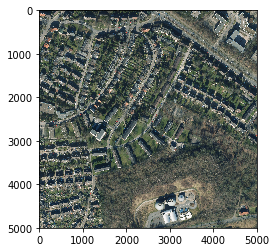

In [156]:
imgl=mpimg.imread('outside_essen.tiff')
imgplot = plt.imshow(imgl)

plt.show() #there you go.

# Splitting the image in tiles of MxN pixels.

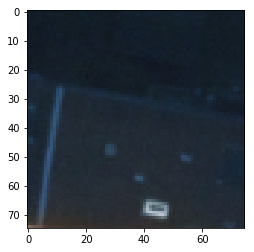

In [157]:
M = 75
N = 75
tiles = [imgl[x:x+M,y:y+N] for x in range(0,imgl.shape[0],M) for y in range(0,imgl.shape[1],N)]

for i in range(0,len(tiles)):
    tiles[i]=cv2.cvtColor(tiles[i], cv2.COLOR_RGBA2RGB)

plt.imshow(tiles[0])

plt.show() #there you go.

4489

# Filtering using a neural network trained on a seed data set of NRW.

In [32]:
#code to set tensorflow backend

!set "KERAS_BACKEND=tensorflow"


import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras; import keras.backend
if keras.backend.backend() != 'tensorflow':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('tf')
    print("Backend ok")

Using TensorFlow backend.


Backend ok


In [90]:
import models
from keras.optimizers import Adam

model = models.fft_vgg(2) #this creates a feature extractor for VGG...

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
model.summary()

model.load_weights("fft_vgg.npy")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FFT_IN (FFT_IN)              (None, 75, 75, 3)         16875     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
activation_9 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 64)        18496     
__________

In [158]:
import numpy as np
from PIL import Image
import traceback


count = 0
for tile in tiles:
    try:
        
        prediction = model.predict(np.expand_dims(tile/255,axis=0))
        print(prediction)
        predicted_class =np.argmax(prediction)
    
        if predicted_class ==0:
        
            myimg = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
            cv2.imwrite("./predictions/neg/img_"+str(count)+".png",myimg)
          
        
        if predicted_class ==1:
            
            myimg = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
            cv2.imwrite("./predictions/pos/img_"+str(count)+".png",myimg)
          
            
        count+=1
    except: 
        print("shape")
        traceback.print_exc()
        print(tile.shape)

[[  9.99892473e-01   1.07529268e-04]]
[[  9.99995589e-01   4.36381606e-06]]
[[  9.99998212e-01   1.84578994e-06]]
[[  9.99993682e-01   6.34382513e-06]]
[[ 0.99011689  0.00988312]]
[[ 0.99455774  0.00544225]]
[[ 0.48958552  0.51041448]]
[[ 0.99443758  0.00556237]]
[[  9.99201119e-01   7.98918365e-04]]
[[ 0.89580619  0.10419381]]
[[  9.99954700e-01   4.53141765e-05]]
[[  9.99510407e-01   4.89595695e-04]]
[[  9.99932885e-01   6.71380767e-05]]
[[  9.99980330e-01   1.97133068e-05]]
[[  9.99998450e-01   1.60496472e-06]]
[[  9.99992967e-01   7.07667232e-06]]
[[ 0.99890053  0.00109941]]
[[  9.99971867e-01   2.81008397e-05]]
[[  9.99869347e-01   1.30578759e-04]]
[[  9.99976397e-01   2.36121705e-05]]
[[  9.99898195e-01   1.01772879e-04]]
[[  9.99991059e-01   8.96483925e-06]]
[[  9.99996424e-01   3.53372297e-06]]
[[  9.99992251e-01   7.74589262e-06]]
[[  9.99940038e-01   6.00084968e-05]]
[[  9.99976158e-01   2.38257217e-05]]
[[  9.99992132e-01   7.90115973e-06]]
[[  9.99992251e-01   7.72708518e-0

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[  9.99930263e-01   6.97460782e-05]]
[[  9.99988198e-01   1.17479949e-05]]
[[  9.99788344e-01   2.11727238e-04]]
[[  9.99967694e-01   3.22987325e-05]]
[[  9.99996305e-01   3.74573756e-06]]
[[  9.99998689e-01   1.29581827e-06]]
[[  9.99980211e-01   1.98161251e-05]]
[[  9.99980807e-01   1.92045354e-05]]
[[  9.99338925e-01   6.61084428e-04]]
[[  9.99956012e-01   4.39287323e-05]]
[[ 0.99256164  0.0074383 ]]
[[  9.99894977e-01   1.05040919e-04]]
[[  9.99998689e-01   1.33118226e-06]]
[[  9.99998569e-01   1.37249822e-06]]
[[  9.99999166e-01   8.01116869e-07]]
[[  9.99967456e-01   3.25048932e-05]]
[[ 0.93318945  0.06681053]]
[[  9.99999285e-01   6.67566951e-07]]
[[  9.99984860e-01   1.51354689e-05]]
[[  9.99810994e-01   1.89079059e-04]]
[[ 0.95023876  0.04976127]]
[[ 0.99194348  0.00805649]]
[[  9.99920130e-01   7.99102636e-05]]
[[  9.99995828e-01   4.22231005e-06]]
[[  9.99530673e-01   4.69342776e-04]]
[[  9.99104559e-01   8.95464618e-04]]
[[  9.99960780e-01   3.92675465e-05]]
[[ 0.97131002

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.99734592  0.002654  ]]
[[ 0.99822432  0.00177567]]
[[ 0.98962003  0.01037996]]
[[ 0.99757761  0.00242236]]
[[  9.99709308e-01   2.90725729e-04]]
[[ 0.99877816  0.00122187]]
[[  9.99998569e-01   1.39302472e-06]]
[[  9.99995470e-01   4.57676424e-06]]
[[  9.99991298e-01   8.65274524e-06]]
[[ 0.95884687  0.04115311]]
[[ 0.54870987  0.45129022]]
[[ 0.99432325  0.00567681]]
[[ 0.97214377  0.02785623]]
[[ 0.36756521  0.63243479]]
[[  9.99977708e-01   2.22592535e-05]]
[[ 0.99689639  0.00310357]]
[[ 0.99850285  0.00149713]]
[[  9.99868274e-01   1.31750188e-04]]
[[ 0.99803573  0.00196433]]
[[  9.99722302e-01   2.77656392e-04]]
[[  9.99892473e-01   1.07536544e-04]]
[[  9.99956489e-01   4.35482580e-05]]
[[  9.99949932e-01   5.01044815e-05]]
[[  9.99988675e-01   1.12747357e-05]]
[[  9.99947906e-01   5.21211878e-05]]
[[ 0.99839032  0.00160974]]
[[  9.99993801e-01   6.20735773e-06]]
[[  9.99712288e-01   2.87647737e-04]]
[[ 0.89549917  0.10450084]]
[[  9.99453604e-01   5.46356663e-04]]
[[ 0.99897

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99578297e-01   4.21655248e-04]]
[[  9.99780715e-01   2.19309644e-04]]
[[ 0.99524164  0.00475835]]
[[  9.99894142e-01   1.05838022e-04]]
[[  9.99898911e-01   1.01038742e-04]]
[[ 0.99755305  0.00244701]]
[[  9.99670148e-01   3.29884992e-04]]
[[  9.99979377e-01   2.05926463e-05]]
[[ 0.96666437  0.0333356 ]]
[[ 0.51711297  0.482887  ]]
[[  9.99980092e-01   1.98765556e-05]]
[[  9.99989152e-01   1.08863087e-05]]
[[  9.99977708e-01   2.23339739e-05]]
[[  9.99986768e-01   1.32714622e-05]]
[[  9.99597967e-01   4.02013742e-04]]
[[  9.99927878e-01   7.20833850e-05]]
[[  9.99933124e-01   6.68298017e-05]]
[[  9.99997854e-01   2.16689455e-06]]
[[  9.99115765e-01   8.84285313e-04]]
[[  9.99845147e-01   1.54857844e-04]]
[[  9.99470770e-01   5.29247860e-04]]
[[  9.99940038e-01   5.99602172e-05]]
[[ 0.7606656   0.23933443]]
[[ 0.99143511  0.00856492]]
[[  9.99949455e-01   5.05614262e-05]]
[[  9.99978781e-01   2.12717368e-05]]
[[  9.99763787e-01   2.36198641e-04]]
[[  9.99953985e-01   4.59854818e-0

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99760330e-01   2.39687317e-04]]
[[  9.99873281e-01   1.26760118e-04]]
[[  9.99855280e-01   1.44641934e-04]]
[[ 0.99854505  0.00145494]]
[[  9.99998450e-01   1.58304738e-06]]
[[  9.99704778e-01   2.95177102e-04]]
[[  9.99867439e-01   1.32534566e-04]]
[[  9.99996424e-01   3.63257868e-06]]
[[  9.99996185e-01   3.85473459e-06]]
[[  9.99999881e-01   1.14937848e-07]]
[[  9.99960542e-01   3.94711096e-05]]
[[  9.99951005e-01   4.89360245e-05]]
[[  9.99982834e-01   1.71772663e-05]]
[[ 0.99141359  0.00858639]]
[[ 0.99738258  0.00261744]]
[[  9.99569595e-01   4.30342450e-04]]
[[  9.99963641e-01   3.63943800e-05]]
[[  9.99995232e-01   4.71311068e-06]]
[[  9.99967217e-01   3.27989619e-05]]
[[  9.99913812e-01   8.62224479e-05]]
[[  9.99942899e-01   5.70688826e-05]]
[[  9.99985814e-01   1.42121671e-05]]
[[ 0.99785608  0.00214395]]
[[  9.99913216e-01   8.68131610e-05]]
[[ 0.98637515  0.01362479]]
[[  9.99925494e-01   7.44852368e-05]]
[[  9.99818027e-01   1.81945579e-04]]
[[  9.99707758e-01   2.9

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.95513904  0.04486091]]
[[ 0.7210356   0.27896446]]
[[ 0.87529421  0.12470579]]
[[  9.99940395e-01   5.96425743e-05]]
[[  9.99910355e-01   8.96519705e-05]]
[[  9.99137402e-01   8.62537010e-04]]
[[  9.99922752e-01   7.72959611e-05]]
[[  9.99980092e-01   1.99045353e-05]]
[[  9.99836326e-01   1.63597855e-04]]
[[  9.99988914e-01   1.10681431e-05]]
[[  9.99618292e-01   3.81735270e-04]]
[[  9.99927044e-01   7.29849271e-05]]
[[  9.99586642e-01   4.13408532e-04]]
[[ 0.99899429  0.00100569]]
[[  9.99972463e-01   2.75691145e-05]]
[[  9.99955416e-01   4.45522783e-05]]
[[  9.99907970e-01   9.20023085e-05]]
[[  9.99800503e-01   1.99576083e-04]]
[[ 0.99832159  0.00167843]]
[[  9.99824464e-01   1.75541922e-04]]
[[  9.99623537e-01   3.76445474e-04]]
[[  9.99874353e-01   1.25597115e-04]]
[[ 0.90093815  0.09906185]]
[[  9.99766052e-01   2.33959538e-04]]
[[  9.99988675e-01   1.13726501e-05]]
[[  9.99969125e-01   3.08253220e-05]]
[[  9.99800026e-01   2.00015958e-04]]
[[  9.99982357e-01   1.76657395e-0

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99968171e-01   3.17944541e-05]]
[[ 0.38806504  0.61193496]]
[[ 0.99754333  0.00245665]]
[[  9.99546587e-01   4.53388784e-04]]
[[  9.99764383e-01   2.35651591e-04]]
[[  9.99789536e-01   2.10479891e-04]]
[[  9.99947190e-01   5.27786542e-05]]
[[  9.99997377e-01   2.57814736e-06]]
[[  9.99613702e-01   3.86319094e-04]]
[[ 0.90144187  0.0985581 ]]
[[  9.99849081e-01   1.50948646e-04]]
[[  9.99556959e-01   4.43079043e-04]]
[[  9.99983191e-01   1.67538401e-05]]
[[  9.99693513e-01   3.06551286e-04]]
[[  9.99961257e-01   3.87430009e-05]]
[[  9.99954581e-01   4.53882567e-05]]
[[  9.99592245e-01   4.07764746e-04]]
[[ 0.9989869  0.0010131]]
[[ 0.9971354   0.00286456]]
[[  9.99722779e-01   2.77165236e-04]]
[[  9.99997377e-01   2.61259106e-06]]
[[ 0.99354547  0.00645447]]
[[ 0.8504656   0.14953448]]
[[ 0.99853373  0.00146631]]
[[ 0.97095102  0.029049  ]]
[[  9.99802291e-01   1.97685586e-04]]
[[  9.99627352e-01   3.72605515e-04]]
[[  9.99809563e-01   1.90409148e-04]]
[[  9.99525189e-01   4.74796

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99950886e-01   4.90731363e-05]]
[[ 0.99856645  0.00143356]]
[[  9.99963999e-01   3.59682599e-05]]
[[  9.99992132e-01   7.83660744e-06]]
[[  9.99865294e-01   1.34714894e-04]]
[[  9.99585807e-01   4.14243666e-04]]
[[ 0.99743384  0.00256614]]
[[  9.99366701e-01   6.33325486e-04]]
[[  9.99662161e-01   3.37865407e-04]]
[[  9.99916553e-01   8.34480452e-05]]
[[  9.99983311e-01   1.67044327e-05]]
[[  9.99948382e-01   5.16300970e-05]]
[[  9.99993801e-01   6.15348608e-06]]
[[  9.99998093e-01   1.95763391e-06]]
[[  9.99953389e-01   4.66653655e-05]]
[[  9.99912858e-01   8.70923395e-05]]
[[  9.99746501e-01   2.53553269e-04]]
[[  9.99856353e-01   1.43661498e-04]]
[[ 0.78704685  0.21295315]]
[[  9.99119699e-01   8.80262698e-04]]
[[ 0.99844813  0.00155188]]
[[ 0.9538849   0.04611513]]
[[ 0.99507529  0.00492467]]
[[ 0.96093744  0.03906256]]
[[  9.99402404e-01   5.97600476e-04]]
[[ 0.94091296  0.05908706]]
[[ 0.98596221  0.01403773]]
[[  9.99986172e-01   1.38152991e-05]]
[[  9.99998689e-01   1.341

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[  9.99984264e-01   1.57634749e-05]]
[[  9.99997854e-01   2.14294050e-06]]
[[  9.99991536e-01   8.42120971e-06]]
[[  9.99987245e-01   1.26984323e-05]]
[[ 0.98487169  0.01512828]]
[[ 0.70811385  0.29188609]]
[[  9.99527454e-01   4.72603249e-04]]
[[  9.99667168e-01   3.32830416e-04]]
[[ 0.99648476  0.00351523]]
[[  9.99824941e-01   1.75076377e-04]]
[[  9.99871135e-01   1.28906526e-04]]
[[  9.99996305e-01   3.67362122e-06]]
[[ 0.99796164  0.00203835]]
[[  9.99218225e-01   7.81717245e-04]]
[[  9.99863863e-01   1.36140414e-04]]
[[  9.99054253e-01   9.45717737e-04]]
[[  9.99909043e-01   9.09765222e-05]]
[[  9.99994516e-01   5.47222407e-06]]
[[  9.99965906e-01   3.41446648e-05]]
[[  9.99837875e-01   1.62075012e-04]]
[[ 0.99875224  0.00124771]]
[[ 0.62531799  0.37468201]]
[[ 0.99853158  0.00146841]]
[[ 0.99828583  0.00171417]]
[[  9.99359906e-01   6.40104001e-04]]
[[  9.99978304e-01   2.16508288e-05]]
[[  9.99856830e-01   1.43184894e-04]]
[[ 0.99801862  0.00198136]]
[[  9.99800861e-01   1.99

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.997235    0.00276505]]
[[ 0.22960579  0.77039415]]
[[ 0.9750846   0.02491535]]
[[  9.99996066e-01   3.95485313e-06]]
[[  9.99999404e-01   6.14817395e-07]]
[[  9.99993443e-01   6.51723758e-06]]
[[  9.99999762e-01   2.31484805e-07]]
[[  9.99997616e-01   2.35955963e-06]]
[[  9.99957919e-01   4.20943143e-05]]
[[  9.99997735e-01   2.30126352e-06]]
[[  9.99984741e-01   1.52478933e-05]]
[[  9.99701679e-01   2.98269675e-04]]
[[  9.99752343e-01   2.47597811e-04]]
[[  9.99953389e-01   4.66540623e-05]]
[[  9.99918699e-01   8.12545186e-05]]
[[  9.99973059e-01   2.69934371e-05]]
[[  9.99723732e-01   2.76263512e-04]]
[[  9.99757707e-01   2.42308161e-04]]
[[  9.99984384e-01   1.56646583e-05]]
[[  9.99819934e-01   1.80092902e-04]]
[[  9.99739349e-01   2.60642293e-04]]
[[  9.99989748e-01   1.03106922e-05]]
[[  9.99963045e-01   3.69811314e-05]]
[[  9.99999404e-01   6.07409504e-07]]
[[  9.99291658e-01   7.08352134e-04]]
[[ 0.99618965  0.00381042]]
[[ 0.9935596   0.00644042]]
[[ 0.62744969  0.3725504

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[  9.99989271e-01   1.07774113e-05]]
[[ 0.99697101  0.00302891]]
[[  9.99697328e-01   3.02655564e-04]]
[[  9.99906540e-01   9.34774725e-05]]
[[  9.99960899e-01   3.90793393e-05]]
[[ 0.99040341  0.00959662]]
[[ 0.99144238  0.00855762]]
[[  9.99999523e-01   4.35392906e-07]]
[[  9.99996543e-01   3.44656905e-06]]
[[  9.99992132e-01   7.84242366e-06]]
[[  9.99986649e-01   1.34007923e-05]]
[[  9.99979734e-01   2.02173633e-05]]
[[  9.99928117e-01   7.18440206e-05]]
[[  9.99659777e-01   3.40255443e-04]]
[[  9.99988556e-01   1.14712511e-05]]
[[  9.99903917e-01   9.60905018e-05]]
[[  9.99231219e-01   7.68764992e-04]]
[[  9.99144554e-01   8.55396327e-04]]
[[  9.99941587e-01   5.83622350e-05]]
[[  9.99978662e-01   2.13258463e-05]]
[[  9.99951720e-01   4.83209878e-05]]
[[ 0.99727279  0.0027272 ]]
[[ 0.24147116  0.75852889]]
[[ 0.9937405   0.00625942]]
[[  9.99992251e-01   7.79172387e-06]]
[[  9.99975562e-01   2.44725688e-05]]
[[  9.99973059e-01   2.69558532e-05]]
[[  9.99729812e-01   2.70206743e-

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99855518e-01   1.44445818e-04]]
[[  9.99978304e-01   2.16712178e-05]]
[[  9.99074340e-01   9.25692206e-04]]
[[  9.99387860e-01   6.12085336e-04]]
[[ 0.89988649  0.10011353]]
[[  9.99568999e-01   4.30984335e-04]]
[[ 0.99812812  0.00187192]]
[[  9.99961495e-01   3.84486229e-05]]
[[ 0.98925704  0.01074289]]
[[  9.99982476e-01   1.75051791e-05]]
[[  9.99950647e-01   4.93424959e-05]]
[[ 0.99803478  0.00196523]]
[[ 0.99796247  0.00203759]]
[[  9.99938607e-01   6.13754892e-05]]
[[  9.99934196e-01   6.57684213e-05]]
[[  9.99950051e-01   4.99172893e-05]]
[[  9.99936581e-01   6.34604949e-05]]
[[  9.99982476e-01   1.74846409e-05]]
[[  9.99989867e-01   1.00887473e-05]]
[[  9.99977589e-01   2.24188625e-05]]
[[  9.99997497e-01   2.51064102e-06]]
[[  9.99563038e-01   4.36952687e-04]]
[[ 0.9846527   0.01534732]]
[[ 0.9923929   0.00760703]]
[[  9.99998093e-01   1.94515610e-06]]
[[  9.99973059e-01   2.69851225e-05]]
[[  9.99993443e-01   6.57845840e-06]]
[[  9.99158025e-01   8.42029171e-04]]
[[ 0.9

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.98827726  0.01172274]]
[[  9.99663472e-01   3.36499215e-04]]
[[ 0.99891496  0.0010851 ]]
[[  9.99619126e-01   3.80895915e-04]]
[[  9.99768436e-01   2.31522121e-04]]
[[  9.99992728e-01   7.29041176e-06]]
[[  9.99963403e-01   3.65541018e-05]]
[[  9.99646306e-01   3.53700656e-04]]
[[  9.99995232e-01   4.77295316e-06]]
[[  9.99792755e-01   2.07218545e-04]]
[[  9.99939442e-01   6.05630339e-05]]
[[ 0.01881295  0.98118711]]
[[ 0.99339288  0.00660712]]
[[  9.99983072e-01   1.68783827e-05]]
[[  9.99860525e-01   1.39510856e-04]]
[[  9.99989986e-01   1.00257048e-05]]
[[  9.99997258e-01   2.70397322e-06]]
[[ 0.99793684  0.00206318]]
[[  9.99954700e-01   4.52382264e-05]]
[[ 0.61757809  0.38242182]]
[[ 0.99264777  0.00735231]]
[[  9.99911308e-01   8.87112474e-05]]
[[ 0.60101366  0.39898634]]
[[  9.99987602e-01   1.24317539e-05]]
[[  9.99995947e-01   4.11250539e-06]]
[[  9.99999404e-01   5.88169257e-07]]
[[  9.99977827e-01   2.21687133e-05]]
[[ 0.99517715  0.00482283]]
[[  9.99982595e-01   1.743

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.99855322  0.00144683]]
[[ 0.98929858  0.0107014 ]]
[[  9.99991894e-01   8.14749001e-06]]
[[  9.99664307e-01   3.35645163e-04]]
[[ 0.99729759  0.00270238]]
[[  9.99761879e-01   2.38147666e-04]]
[[  9.99694824e-01   3.05184803e-04]]
[[ 0.99858791  0.00141204]]
[[ 0.80241609  0.19758385]]
[[ 0.99883121  0.00116879]]
[[ 0.45302513  0.5469749 ]]
[[  9.99984264e-01   1.57073791e-05]]
[[  9.99988198e-01   1.18261423e-05]]
[[  9.99988794e-01   1.12382386e-05]]
[[  9.99947906e-01   5.21272523e-05]]
[[  9.99926567e-01   7.34124624e-05]]
[[  9.99947190e-01   5.28187848e-05]]
[[  9.99994874e-01   5.18440993e-06]]
[[  9.99875307e-01   1.24714483e-04]]
[[  9.99047220e-01   9.52799805e-04]]
[[  9.99951243e-01   4.87032448e-05]]
[[  9.99266446e-01   7.33579509e-04]]
[[ 0.59394062  0.40605938]]
[[ 0.92610949  0.07389048]]
[[  9.99948025e-01   5.20030226e-05]]
[[  9.99959350e-01   4.06280378e-05]]
[[  9.99966025e-01   3.40110964e-05]]
[[  9.99992847e-01   7.20958042e-06]]
[[  9.99960303e-01   3.974

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.98868072  0.01131931]]
[[  9.99961615e-01   3.83858678e-05]]
[[  9.99998808e-01   1.23262737e-06]]
[[  9.99932766e-01   6.72652750e-05]]
[[ 0.97864419  0.0213558 ]]
[[ 0.99360472  0.00639529]]
[[ 0.99125856  0.0087414 ]]
[[ 0.89234215  0.10765784]]
[[  9.99992132e-01   7.90628565e-06]]
[[  9.99936819e-01   6.32277515e-05]]
[[  9.99983907e-01   1.61373646e-05]]
[[ 0.99693334  0.00306659]]
[[  9.99992490e-01   7.55875089e-06]]
[[  9.99965549e-01   3.44229557e-05]]
[[ 0.97527301  0.02472695]]
[[ 0.99065816  0.0093418 ]]
[[  9.99648333e-01   3.51695344e-04]]
[[  9.99966621e-01   3.34256911e-05]]
[[  9.99999285e-01   7.48257207e-07]]
[[  9.99997854e-01   2.08809524e-06]]
[[  9.99827325e-01   1.72699452e-04]]
[[  9.99949932e-01   5.00927308e-05]]
[[ 0.88192946  0.11807053]]
[[ 0.99590069  0.00409929]]
[[  9.99816358e-01   1.83693119e-04]]
[[ 0.99734676  0.00265325]]
[[  9.99983430e-01   1.65549609e-05]]
[[ 0.99821186  0.00178814]]
[[  9.99929667e-01   7.03155965e-05]]
[[  9.99999523e-01

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.14048727  0.85951275]]
[[  9.99988675e-01   1.13402575e-05]]
[[  9.99886990e-01   1.13047849e-04]]
[[ 0.9946174   0.00538262]]
[[  9.99962687e-01   3.73117437e-05]]
[[  9.99965310e-01   3.47072928e-05]]
[[  9.99964237e-01   3.57605204e-05]]
[[  9.99465168e-01   5.34812629e-04]]
[[  9.99152899e-01   8.47078452e-04]]
[[ 0.97817904  0.02182096]]
[[  9.99928832e-01   7.12146502e-05]]
[[ 0.99528682  0.00471315]]
[[  9.99689102e-01   3.10880103e-04]]
[[ 0.17796117  0.82203883]]
[[  9.99975562e-01   2.44388211e-05]]
[[ 0.99845517  0.00154485]]
[[  9.99963045e-01   3.69209083e-05]]
[[  9.99984503e-01   1.55310063e-05]]
[[  9.99925137e-01   7.48386592e-05]]
[[ 0.99878603  0.001214  ]]
[[  9.99279916e-01   7.20052223e-04]]
[[  9.99418497e-01   5.81486674e-04]]
[[ 0.99750793  0.00249203]]
[[  9.99554455e-01   4.45539365e-04]]
[[  9.99723375e-01   2.76563660e-04]]
[[ 0.94477135  0.05522861]]
[[  9.99985099e-01   1.49102152e-05]]
[[  9.99995470e-01   4.51110554e-06]]
[[  9.99987125e-01   1.286

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99988437e-01   1.15949961e-05]]
[[  9.99992132e-01   7.81608105e-06]]
[[  9.99997616e-01   2.39649330e-06]]
[[ 0.99847716  0.00152284]]
[[ 0.98948729  0.01051266]]
[[ 0.98858136  0.01141861]]
[[  9.99407411e-01   5.92632045e-04]]
[[ 0.9914397   0.00856029]]
[[  9.99841452e-01   1.58477007e-04]]
[[ 0.98366952  0.01633043]]
[[  9.99989867e-01   1.01452861e-05]]
[[  9.99990463e-01   9.53111066e-06]]
[[  9.99502063e-01   4.97955072e-04]]
[[  9.99914646e-01   8.52940138e-05]]
[[  9.99007761e-01   9.92280780e-04]]
[[  9.99933720e-01   6.62853563e-05]]
[[  9.99827087e-01   1.72891407e-04]]
[[ 0.99663264  0.0033674 ]]
[[ 0.9978745   0.00212549]]
[[ 0.99484903  0.00515097]]
[[ 0.88619214  0.11380783]]
[[  9.99878407e-01   1.21527977e-04]]
[[  9.99982476e-01   1.74665092e-05]]
[[  9.99981165e-01   1.88234681e-05]]
[[  9.99990940e-01   9.07314370e-06]]
[[  9.99884367e-01   1.15634175e-04]]
[[  9.99990821e-01   9.20863476e-06]]
[[  9.99849796e-01   1.50176405e-04]]
[[  9.99992847e-01   7.158

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[ 0.99820304  0.00179696]]
[[  9.99937534e-01   6.24800305e-05]]
[[  9.99904871e-01   9.50957256e-05]]
[[  9.99914765e-01   8.52149242e-05]]
[[  9.99981523e-01   1.84487144e-05]]
[[  9.99997020e-01   3.02103649e-06]]
[[  9.99995470e-01   4.53643861e-06]]
[[  9.99995708e-01   4.29804641e-06]]
[[  9.99848843e-01   1.51192668e-04]]
[[  9.99924660e-01   7.53170534e-05]]
[[ 0.99655652  0.00344347]]
[[  9.99806702e-01   1.93325948e-04]]
[[  9.99740541e-01   2.59450695e-04]]
[[  9.99959826e-01   4.01141915e-05]]
[[  9.99992490e-01   7.54528264e-06]]
[[  9.99935985e-01   6.39717255e-05]]
[[ 0.99524152  0.0047585 ]]
[[  9.99816358e-01   1.83629716e-04]]
[[ 0.96920723  0.03079272]]
[[ 0.99245209  0.00754794]]
[[ 0.98903567  0.01096436]]
[[  9.99969006e-01   3.09941970e-05]]
[[  9.99956965e-01   4.30625223e-05]]
[[  9.99997497e-01   2.50367839e-06]]
[[  9.99945402e-01   5.45555486e-05]]
[[  9.99950886e-01   4.91078754e-05]]
[[ 0.86788839  0.13211158]]
[[  9.99570191e-01   4.29826934e-04]]
[[ 0.

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99995470e-01   4.53400344e-06]]
[[  9.99924779e-01   7.51780608e-05]]
[[  9.99833703e-01   1.66275800e-04]]
[[  9.99781787e-01   2.18224159e-04]]
[[  9.99974012e-01   2.60009365e-05]]
[[  9.99999762e-01   1.81658294e-07]]
[[  9.99794900e-01   2.05123637e-04]]
[[ 0.98928893  0.01071108]]
[[  9.99988914e-01   1.10553156e-05]]
[[  9.99911547e-01   8.83947432e-05]]
[[ 0.99676251  0.00323747]]
[[  9.99688148e-01   3.11927550e-04]]
[[ 0.99679404  0.00320599]]
[[  9.99997735e-01   2.28816384e-06]]
[[  9.99894261e-01   1.05688152e-04]]
[[  9.99972582e-01   2.74046542e-05]]
[[  9.99984384e-01   1.55810885e-05]]
[[ 0.99724847  0.00275152]]
[[ 0.98547423  0.01452578]]
[[  9.99969006e-01   3.09686111e-05]]
[[ 0.99392009  0.00607986]]
[[  9.99294162e-01   7.05824525e-04]]
[[  9.99993086e-01   6.91510240e-06]]
[[  9.99946117e-01   5.38506210e-05]]
[[  9.99943733e-01   5.63190770e-05]]
[[  9.99991894e-01   8.07272227e-06]]
[[  9.99615192e-01   3.84719257e-04]]
[[  9.99552429e-01   4.47574130e-0

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99960065e-01   3.99433738e-05]]
[[  9.99998093e-01   1.92286279e-06]]
[[  9.99998808e-01   1.16718957e-06]]
[[ 0.99878389  0.00121614]]
[[ 0.96989036  0.0301096 ]]
[[ 0.99057686  0.00942314]]
[[  9.99992251e-01   7.70293082e-06]]
[[  9.99955058e-01   4.49720574e-05]]
[[ 0.99888688  0.00111307]]
[[ 0.91210842  0.08789157]]
[[  9.99915838e-01   8.41304718e-05]]
[[  9.99986410e-01   1.35831751e-05]]
[[  9.99988675e-01   1.13785845e-05]]
[[  9.99064147e-01   9.35919874e-04]]
[[ 0.9930647   0.00693531]]
[[ 0.99485117  0.00514886]]
[[  9.99976516e-01   2.34947420e-05]]
[[ 0.98316205  0.01683795]]
[[ 0.98287624  0.01712381]]
[[  9.99652028e-01   3.47950816e-04]]
[[  9.99973059e-01   2.69207849e-05]]
[[  9.99999642e-01   3.46137114e-07]]
[[  9.99907732e-01   9.22841064e-05]]
[[  9.99941230e-01   5.88090188e-05]]
[[  9.99989390e-01   1.05808595e-05]]
[[ 0.95600659  0.04399338]]
[[  9.99992728e-01   7.31846421e-06]]
[[  9.99988556e-01   1.14704635e-05]]
[[ 0.99884063  0.00115944]]
[[  9.99

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



(75, 50, 3)
[[  9.99877214e-01   1.22818325e-04]]
[[  9.99731243e-01   2.68774049e-04]]
[[ 0.99712092  0.0028791 ]]
[[  9.99998927e-01   1.10188853e-06]]
[[  9.99989510e-01   1.04718811e-05]]
[[  9.99818623e-01   1.81365685e-04]]
[[  9.99566495e-01   4.33502108e-04]]
[[  9.99854803e-01   1.45201891e-04]]
[[  9.99963880e-01   3.60763333e-05]]
[[  9.99995351e-01   4.63778952e-06]]
[[  9.99999046e-01   8.99742815e-07]]
[[ 0.99539077  0.0046092 ]]
[[ 0.99637443  0.00362553]]
[[ 0.99772221  0.00227783]]
[[ 0.91623884  0.08376113]]
[[  9.99381185e-01   6.18777412e-04]]
[[  9.99995470e-01   4.48120636e-06]]
[[  9.99992251e-01   7.77210971e-06]]
[[  9.99702871e-01   2.97121907e-04]]
[[ 0.33536127  0.6646387 ]]
[[  9.99235868e-01   7.64179509e-04]]
[[ 0.9984628   0.00153717]]
[[ 0.99897385  0.00102617]]
[[ 0.99799287  0.00200718]]
[[  9.99390960e-01   6.08976581e-04]]
[[  9.99261677e-01   7.38338858e-04]]
[[  9.99972224e-01   2.77708714e-05]]
[[  9.99963522e-01   3.65021660e-05]]
[[  9.9999713

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99682546e-01   3.17507307e-04]]
[[  9.99777853e-01   2.22126211e-04]]
[[  9.99973416e-01   2.65300296e-05]]
[[ 0.30571628  0.69428372]]
[[  9.99997735e-01   2.30294518e-06]]
[[ 0.72143519  0.27856481]]
[[ 0.76628697  0.23371303]]
[[  9.99941230e-01   5.88195653e-05]]
[[  9.99979377e-01   2.06769510e-05]]
[[  9.99961615e-01   3.83469378e-05]]
[[  9.99273717e-01   7.26243132e-04]]
[[ 0.49587673  0.50412327]]
[[  9.99190748e-01   8.09224381e-04]]
[[  9.99842644e-01   1.57340517e-04]]
[[ 0.97652537  0.02347457]]
[[ 0.50714529  0.49285468]]
[[  9.99702275e-01   2.97712279e-04]]
[[  9.99888778e-01   1.11258043e-04]]
[[  9.99984503e-01   1.55219150e-05]]
[[  9.99993801e-01   6.18333479e-06]]
[[  9.99896049e-01   1.03966180e-04]]
[[ 0.08952661  0.91047335]]
[[ 0.96048915  0.03951077]]
[[ 0.99087989  0.00912008]]
[[ 0.72352076  0.27647927]]
[[ 0.92191088  0.07808916]]
[[  9.99999762e-01   2.44163715e-07]]
[[  9.99955535e-01   4.44392826e-05]]
[[  9.99997973e-01   1.98426005e-06]]
[[  9.99

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99999166e-01   8.90840226e-07]]
[[  9.99203742e-01   7.96300767e-04]]
[[ 0.9988637   0.00113627]]
[[ 0.99874169  0.00125834]]
[[  9.99997377e-01   2.59848707e-06]]
[[ 0.99090427  0.00909576]]
[[  9.99998927e-01   1.06229345e-06]]
[[  9.99981403e-01   1.85868284e-05]]
[[ 0.99061275  0.00938724]]
[[ 0.36087191  0.63912809]]
[[  9.99989629e-01   1.03880711e-05]]
[[  9.99900818e-01   9.91497000e-05]]
[[ 0.98367393  0.01632607]]
[[ 0.99784625  0.00215374]]
[[  9.99994874e-01   5.14922294e-06]]
[[  9.99625802e-01   3.74171912e-04]]
[[  9.99076724e-01   9.23212676e-04]]
[[  9.99448478e-01   5.51505073e-04]]
[[  9.99986529e-01   1.34262727e-05]]
[[  9.99864817e-01   1.35183160e-04]]
[[  9.99995351e-01   4.66639585e-06]]
[[  9.99967456e-01   3.24941066e-05]]
[[  9.99998689e-01   1.25894439e-06]]
[[ 0.99751663  0.00248337]]
[[ 0.89322108  0.10677888]]
[[  9.99976158e-01   2.38923658e-05]]
[[  9.99988675e-01   1.13428314e-05]]
[[ 0.62948644  0.37051356]]
[[  9.99941349e-01   5.86111564e-05]

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99987245e-01   1.27685253e-05]]
[[ 0.98281109  0.01718889]]
[[ 0.99285311  0.00714687]]
[[ 0.91742927  0.08257074]]
[[ 0.8008495   0.19915044]]
[[  9.99272525e-01   7.27431034e-04]]
[[ 0.89813423  0.10186576]]
[[  9.99991179e-01   8.84054498e-06]]
[[ 0.28535286  0.71464711]]
[[  9.99959469e-01   4.04799939e-05]]
[[  9.99943137e-01   5.68060859e-05]]
[[  9.99998569e-01   1.42226725e-06]]
[[  9.99953151e-01   4.68016442e-05]]
[[ 0.55990124  0.44009873]]
[[ 0.98107773  0.01892222]]
[[  9.99670982e-01   3.29046656e-04]]
[[ 0.29507881  0.70492119]]
[[ 0.99895597  0.00104399]]
[[  9.99977827e-01   2.22206545e-05]]
[[  9.99995828e-01   4.17433694e-06]]
[[  9.99976754e-01   2.32232833e-05]]
[[  9.99297976e-01   7.01963960e-04]]
[[ 0.99845898  0.00154102]]
[[  9.99980688e-01   1.93272863e-05]]
[[ 0.99885523  0.00114478]]
[[ 0.97003931  0.0299607 ]]
[[ 0.99312156  0.0068784 ]]
[[  9.99937534e-01   6.24934910e-05]]
[[ 0.97623199  0.02376799]]
[[ 0.9979201   0.00207998]]
[[ 0.99792022  0.002

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99995947e-01   4.03998411e-06]]
[[  9.99934554e-01   6.54054238e-05]]
[[ 0.07016905  0.92983103]]
[[  9.99967098e-01   3.28589449e-05]]
[[  9.99963880e-01   3.61062048e-05]]
[[  9.99273002e-01   7.27000006e-04]]
[[  9.99968648e-01   3.13814089e-05]]
[[  9.99830961e-01   1.69015286e-04]]
[[  9.99975085e-01   2.49030036e-05]]
[[  9.99971032e-01   2.89547024e-05]]
[[ 0.29648834  0.70351166]]
[[ 0.98966002  0.01033992]]
[[ 0.58011883  0.41988117]]
[[  9.99579608e-01   4.20402648e-04]]
[[  9.99993324e-01   6.64125446e-06]]
[[  9.99992251e-01   7.79734364e-06]]
[[  9.99870062e-01   1.29916691e-04]]
[[  9.99990225e-01   9.80490950e-06]]
[[  9.99986053e-01   1.38946289e-05]]
[[ 0.9918161   0.00818395]]
[[ 0.97415304  0.02584697]]
[[  9.99291658e-01   7.08316977e-04]]
[[ 0.83280665  0.16719341]]
[[ 0.97385526  0.02614472]]
[[ 0.99849582  0.00150416]]
[[  9.99958038e-01   4.19479657e-05]]
[[  9.99997020e-01   2.92954178e-06]]
[[  9.99995232e-01   4.78798893e-06]]
[[ 0.98081172  0.01918831]

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.98598772  0.01401231]]
[[ 0.99827039  0.00172965]]
[[  9.99929070e-01   7.09423693e-05]]
[[  9.99008000e-01   9.92043526e-04]]
[[  9.99979258e-01   2.07465728e-05]]
[[ 0.99891555  0.00108442]]
[[  9.99971271e-01   2.87044877e-05]]
[[  9.99989986e-01   9.97792631e-06]]
[[  9.99457061e-01   5.42922411e-04]]
[[ 0.99844593  0.00155411]]
[[  9.99983430e-01   1.65335969e-05]]
[[  9.99996424e-01   3.57551403e-06]]
[[  9.99101400e-01   8.98641651e-04]]
[[ 0.96275228  0.03724768]]
[[ 0.99173927  0.00826071]]
[[  9.99544680e-01   4.55244939e-04]]
[[  9.99327540e-01   6.72513386e-04]]
[[  9.99867082e-01   1.32895861e-04]]
[[  9.99990463e-01   9.54255211e-06]]
[[  9.99999523e-01   4.69852040e-07]]
[[  9.99997973e-01   1.96713677e-06]]
[[  9.99724448e-01   2.75504659e-04]]
[[  9.99969244e-01   3.07841692e-05]]
[[ 0.99603719  0.00396282]]
[[  9.99986887e-01   1.30676035e-05]]
[[ 0.32371855  0.67628145]]
[[ 0.9927147   0.00728531]]
[[  9.99767482e-01   2.32487670e-04]]
[[  9.99949098e-01   5.092

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[ 0.93032968  0.06967031]]
[[ 0.83623236  0.16376761]]
[[  9.99862909e-01   1.37063005e-04]]
[[  9.99044716e-01   9.55243479e-04]]
[[  9.99173939e-01   8.26026138e-04]]
[[  9.99964237e-01   3.57273202e-05]]
[[ 0.99846786  0.00153205]]
[[  9.99613345e-01   3.86694592e-04]]
[[  9.99992609e-01   7.40050245e-06]]
[[  9.99980569e-01   1.93964352e-05]]
[[  9.99955058e-01   4.49228937e-05]]
[[  9.99993324e-01   6.71145654e-06]]
[[  9.99978185e-01   2.18067180e-05]]
[[  9.99680281e-01   3.19770130e-04]]
[[ 0.94098073  0.05901931]]
[[ 0.99636108  0.00363893]]
[[  9.99624968e-01   3.75000032e-04]]
[[ 0.92143208  0.07856791]]
[[  9.99565780e-01   4.34151996e-04]]
[[  9.99164701e-01   8.35262123e-04]]
[[  9.99994636e-01   5.32351396e-06]]
[[  9.99969840e-01   3.01275049e-05]]
[[  9.99994755e-01   5.28885630e-06]]
[[ 0.99754     0.00245997]]
[[  9.99687076e-01   3.12965945e-04]]
[[ 0.99477792  0.00522206]]
[[ 0.99831641  0.00168362]]
[[  9.99999046e-01   9.46995726e-07]]
[[  9.99989510e-01   1.04

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99952435e-01   4.76209389e-05]]
[[  9.99987245e-01   1.27163685e-05]]
[[  9.99935627e-01   6.43861276e-05]]
[[ 0.7799201   0.22007984]]
[[  9.99734104e-01   2.65932205e-04]]
[[  9.99997139e-01   2.85763758e-06]]
[[  9.99969959e-01   3.00741722e-05]]
[[  9.99995828e-01   4.15606473e-06]]
[[  9.99979258e-01   2.06945242e-05]]
[[  9.99995470e-01   4.47478760e-06]]
[[  9.99119103e-01   8.80895765e-04]]
[[  9.99872684e-01   1.27358886e-04]]
[[ 0.97000074  0.02999928]]
[[  9.99871492e-01   1.28513668e-04]]
[[ 0.93135154  0.06864847]]
[[ 0.99855751  0.0014425 ]]
[[ 0.99896181  0.00103813]]
[[  9.99991655e-01   8.35481478e-06]]
[[  9.99992967e-01   6.99905740e-06]]
[[  9.99997020e-01   2.98637019e-06]]
[[  9.99993801e-01   6.23322194e-06]]
[[  9.99982595e-01   1.74068937e-05]]
[[  9.99842286e-01   1.57716931e-04]]
[[  9.99651432e-01   3.48570349e-04]]
[[  9.99999046e-01   9.11634515e-07]]
[[  9.99994755e-01   5.26584608e-06]]
[[ 0.862414    0.13758594]]
[[  9.99953628e-01   4.63982324e-0

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99904156e-01   9.57896918e-05]]
[[ 0.98986346  0.01013652]]
[[ 0.99859005  0.00140992]]
[[ 0.98507893  0.0149211 ]]
[[  9.99964118e-01   3.59075348e-05]]
[[ 0.94631135  0.05368868]]
[[  9.99998689e-01   1.32113905e-06]]
[[  9.99223113e-01   7.76856847e-04]]
[[  9.99821603e-01   1.78411588e-04]]
[[  9.99820888e-01   1.79163384e-04]]
[[ 0.99318051  0.00681947]]
[[ 0.974626    0.02537395]]
[[  9.99982595e-01   1.73521003e-05]]
[[  9.99984503e-01   1.55335401e-05]]
[[  9.99993324e-01   6.72406486e-06]]
[[  9.99995828e-01   4.14007491e-06]]
[[  9.99924302e-01   7.57404196e-05]]
[[  9.99834776e-01   1.65211575e-04]]
[[ 0.90586728  0.09413274]]
[[  9.99015570e-01   9.84383980e-04]]
[[  9.99339163e-01   6.60790247e-04]]
[[  9.99844313e-01   1.55644215e-04]]
[[  9.99991536e-01   8.43656198e-06]]
[[  9.99947906e-01   5.20739850e-05]]
[[  9.99993324e-01   6.66194637e-06]]
[[  9.99971032e-01   2.89240670e-05]]
[[  9.99990702e-01   9.32963030e-06]]
[[  9.99915719e-01   8.42292793e-05]]
[[  9.

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99871254e-01   1.28718108e-04]]
[[ 0.89867103  0.10132899]]
[[  9.99966860e-01   3.31315314e-05]]
[[ 0.95358968  0.04641038]]
[[  9.99935746e-01   6.41953957e-05]]
[[  9.99977231e-01   2.27680339e-05]]
[[  9.99979615e-01   2.04332937e-05]]
[[  9.99938488e-01   6.15076715e-05]]
[[  9.99994278e-01   5.74190562e-06]]
[[  9.99935031e-01   6.49054928e-05]]
[[  9.99982357e-01   1.76210997e-05]]
[[ 0.99886763  0.00113245]]
[[  9.99780476e-01   2.19563866e-04]]
[[  9.99967813e-01   3.21489861e-05]]
[[ 0.75039357  0.24960645]]
[[ 0.99495173  0.00504835]]
[[ 0.97003001  0.02997004]]
[[ 0.99743879  0.00256118]]
[[  9.99674678e-01   3.25387460e-04]]
[[  9.99999404e-01   5.76756179e-07]]
[[  9.99999404e-01   5.46002866e-07]]
[[  9.99950528e-01   4.95014174e-05]]
[[  9.99971867e-01   2.81679186e-05]]
[[ 0.99822325  0.0017767 ]]
[[  9.99983907e-01   1.60494219e-05]]
[[ 0.966564    0.03343598]]
[[ 0.9773891  0.0226109]]
[[ 0.13517548  0.86482447]]
[[ 0.9172585   0.08274142]]
[[  9.99947548e-01  

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)
[[  9.99806941e-01   1.93113723e-04]]
[[  9.99916553e-01   8.34144594e-05]]
[[  9.99713957e-01   2.86000955e-04]]
[[  9.99985099e-01   1.48735735e-05]]
[[  9.99834418e-01   1.65569712e-04]]
[[ 0.9930703   0.00692964]]
[[  9.99807417e-01   1.92625477e-04]]
[[  9.99912858e-01   8.71755183e-05]]
[[ 0.99698228  0.00301774]]
[[ 0.96932137  0.03067862]]
[[ 0.98988265  0.01011738]]
[[ 0.55305713  0.44694287]]
[[ 0.96282643  0.03717351]]
[[  9.99900341e-01   9.96611998e-05]]
[[  9.99917984e-01   8.19737106e-05]]
[[ 0.99724364  0.00275643]]
[[ 0.9748317   0.02516828]]
[[ 0.97137558  0.02862439]]
[[  9.99983788e-01   1.62609213e-05]]
[[  9.99995947e-01   4.06801382e-06]]
[[  9.99992967e-01   7.07729305e-06]]
[[  9.99996662e-01   3.34844299e-06]]
[[  9.99022961e-01   9.76989046e-04]]
[[  9.99935031e-01   6.50012662e-05]]
[[  9.99741852e-01   2.58153072e-04]]
[[ 0.98242491  0.01757507]]
[[  9.99304056e-01   6.95983588e-04]]
[[ 0.99473345  0.00526654]]
[[ 0.92724442  0.07275552]]
[[  9.

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99981284e-01   1.87355527e-05]]
[[  9.99009371e-01   9.90548404e-04]]
[[  9.99966145e-01   3.38257851e-05]]
[[ 0.9574753  0.0425247]]
[[ 0.99764109  0.0023589 ]]
[[ 0.94653052  0.05346949]]
[[  9.99948502e-01   5.14611020e-05]]
[[ 0.99847573  0.00152426]]
[[ 0.93738389  0.06261607]]
[[  9.99994636e-01   5.32614422e-06]]
[[  9.99998212e-01   1.82016890e-06]]
[[  9.99964714e-01   3.52824209e-05]]
[[ 0.99852461  0.00147537]]
[[  9.99063194e-01   9.36827157e-04]]
[[  9.99982715e-01   1.73445242e-05]]
[[  9.99918580e-01   8.14380546e-05]]
[[  9.99989390e-01   1.06649450e-05]]
[[  9.99988675e-01   1.12825346e-05]]
[[  9.99420762e-01   5.79294458e-04]]
[[ 0.25854531  0.74145472]]
[[  9.99963522e-01   3.65105225e-05]]
[[  9.99993682e-01   6.26710744e-06]]
[[  9.99994874e-01   5.10981408e-06]]
[[  9.99993324e-01   6.64598701e-06]]
[[  9.99998927e-01   1.05265644e-06]]
[[  9.99992371e-01   7.64879860e-06]]
[[  9.99999762e-01   1.93623734e-07]]
[[  9.99997258e-01   2.68765825e-06]]
[[  9.99

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



(75, 50, 3)
[[  9.99997020e-01   2.99963722e-06]]
[[  9.99997258e-01   2.77322238e-06]]
[[  9.99994159e-01   5.87816521e-06]]
[[  9.99998808e-01   1.20762707e-06]]
[[  9.99949932e-01   5.00550996e-05]]
[[  9.99520302e-01   4.79658949e-04]]
[[  9.99993920e-01   6.03703484e-06]]
[[  9.99990106e-01   9.84347116e-06]]
[[  9.99998450e-01   1.57001671e-06]]
[[  9.99215245e-01   7.84725766e-04]]
[[ 0.99613875  0.00386128]]
[[ 0.87486738  0.12513264]]
[[  9.99958515e-01   4.14584065e-05]]
[[  9.99638319e-01   3.61656566e-04]]
[[ 0.99126738  0.00873267]]
[[  9.99991894e-01   8.15717704e-06]]
[[ 0.9960168   0.00398318]]
[[  9.99958873e-01   4.11820693e-05]]
[[  9.99986410e-01   1.36473973e-05]]
[[  9.99986291e-01   1.36947092e-05]]
[[  9.99401450e-01   5.98546641e-04]]
[[ 0.99814773  0.00185235]]
[[  9.99950051e-01   4.99045345e-05]]
[[  9.99975085e-01   2.49597088e-05]]
[[  9.99063432e-01   9.36545548e-04]]
[[  9.99992847e-01   7.15451870e-06]]
[[  9.99977112e-01   2.29132565e-05]]
[[  9.99996

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99772847e-01   2.27158554e-04]]
[[  9.99720275e-01   2.79691827e-04]]
[[ 0.99479336  0.00520665]]
[[ 0.99433208  0.00566798]]
[[  9.99981880e-01   1.81641026e-05]]
[[ 0.97024769  0.02975229]]
[[  9.99850392e-01   1.49629952e-04]]
[[  9.99907374e-01   9.26756547e-05]]
[[  9.99817908e-01   1.82103540e-04]]
[[  9.99809325e-01   1.90649123e-04]]
[[  9.99964118e-01   3.58455691e-05]]
[[  9.99996185e-01   3.80186202e-06]]
[[  9.99982953e-01   1.69951436e-05]]
[[ 0.99465734  0.00534269]]
[[ 0.99855846  0.00144157]]
[[  9.99863863e-01   1.36089278e-04]]
[[  9.99895096e-01   1.04905681e-04]]
[[ 0.99887437  0.00112559]]
[[  9.99808609e-01   1.91366518e-04]]
[[  9.99991298e-01   8.73900808e-06]]
[[ 0.97286701  0.02713298]]
[[ 0.66956198  0.33043802]]
[[ 0.99845636  0.00154368]]
[[  9.99984145e-01   1.57965333e-05]]
[[  9.99798238e-01   2.01728384e-04]]
[[  9.99955535e-01   4.45186051e-05]]
[[  9.99978065e-01   2.18958030e-05]]
[[  9.99954700e-01   4.52395616e-05]]
[[  9.99525666e-01   4.743

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99935389e-01   6.46342305e-05]]
[[ 0.9931705   0.00682956]]
[[ 0.99253207  0.00746797]]
[[ 0.24993348  0.75006652]]
[[ 0.41234431  0.58765566]]
[[ 0.92930907  0.07069099]]
[[  9.99682546e-01   3.17491242e-04]]
[[  9.99776661e-01   2.23331605e-04]]
[[  9.99460876e-01   5.39104105e-04]]
[[  9.99912381e-01   8.76010963e-05]]
[[ 0.99835569  0.00164425]]
[[  9.99825180e-01   1.74829489e-04]]
[[  9.99952078e-01   4.79670562e-05]]
[[  9.99988556e-01   1.14802906e-05]]
[[  9.99718845e-01   2.81103625e-04]]
[[  9.99176919e-01   8.23046023e-04]]
[[  9.99714673e-01   2.85289891e-04]]
[[ 0.95826691  0.04173306]]
[[ 0.93676323  0.06323671]]
[[  9.99941111e-01   5.88971307e-05]]
[[ 0.99252772  0.0074723 ]]
[[ 0.9823131   0.01768686]]
[[  9.99994516e-01   5.43555552e-06]]
[[ 0.99575812  0.00424185]]
[[  9.99995112e-01   4.88322394e-06]]
[[  9.99953985e-01   4.59991679e-05]]
[[  9.99999166e-01   8.30431247e-07]]
[[  9.99965787e-01   3.41542036e-05]]
[[ 0.99787605  0.00212398]]
[[ 0.24661274  0.7

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99184072e-01   8.15965701e-04]]
[[  9.99529958e-01   4.70012077e-04]]
[[  9.99919176e-01   8.08040350e-05]]
[[  9.99636769e-01   3.63228202e-04]]
[[  9.99995470e-01   4.47160073e-06]]
[[  9.99907374e-01   9.26719440e-05]]
[[  9.99992132e-01   7.91716593e-06]]
[[  9.99945879e-01   5.41007284e-05]]
[[  9.99997377e-01   2.59205694e-06]]
[[  9.99999762e-01   2.13917005e-07]]
[[ 0.99865961  0.0013404 ]]
[[  9.99958515e-01   4.14354035e-05]]
[[ 0.95405066  0.04594934]]
[[ 0.96714652  0.03285353]]
[[ 0.46507213  0.5349279 ]]
[[  9.99989390e-01   1.05998461e-05]]
[[  9.99856830e-01   1.43138212e-04]]
[[  9.99548018e-01   4.51990432e-04]]
[[ 0.99445277  0.00554721]]
[[ 0.98935801  0.01064197]]
[[  9.99997973e-01   2.07398693e-06]]
[[  9.99973774e-01   2.62139547e-05]]
[[  9.99962330e-01   3.76749449e-05]]
[[  9.99785364e-01   2.14656131e-04]]
[[ 0.99634188  0.00365813]]
[[ 0.99705964  0.00294038]]
[[  9.99986410e-01   1.35422770e-05]]
[[  9.99999285e-01   6.93433265e-07]]
[[  9.99944210e-

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[  9.99641299e-01   3.58648715e-04]]
[[  9.99608576e-01   3.91471520e-04]]
[[ 0.99804628  0.00195374]]
[[  9.99562204e-01   4.37791139e-04]]
[[ 0.96959287  0.03040714]]
[[  9.99956131e-01   4.39042815e-05]]
[[  9.99446809e-01   5.53145423e-04]]
[[  9.99937296e-01   6.27280242e-05]]
[[  9.99994755e-01   5.19469359e-06]]
[[  9.99977469e-01   2.24922496e-05]]
[[ 0.99370283  0.00629709]]
[[  9.99969363e-01   3.05816829e-05]]
[[ 0.99883538  0.00116459]]
[[ 0.98575646  0.01424349]]
[[  9.99013901e-01   9.86038242e-04]]
[[  9.99996305e-01   3.66833842e-06]]
[[  9.99723852e-01   2.76101578e-04]]
[[ 0.80744869  0.19255126]]
[[  9.99999642e-01   4.00469048e-07]]
[[  9.99996066e-01   3.95624147e-06]]
[[ 0.76402515  0.23597489]]
[[ 0.93472427  0.06527579]]
[[ 0.786264  0.213736]]
[[  9.99999642e-01   3.49964864e-07]]
[[  9.99997258e-01   2.69585735e-06]]
[[  9.99993920e-01   6.07246602e-06]]
[[  9.99973655e-01   2.63356578e-05]]
[[  9.99789536e-01   2.10505794e-04]]
[[  9.99714553e-01   2.854275

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[  9.99996543e-01   3.49497668e-06]]
[[  9.99994755e-01   5.19407922e-06]]
[[  9.99985099e-01   1.49082252e-05]]
[[  9.99132454e-01   8.67592404e-04]]
[[  9.99991775e-01   8.21442973e-06]]
[[  9.99994636e-01   5.39580788e-06]]
[[  9.99867439e-01   1.32523448e-04]]
[[  9.99834776e-01   1.65138961e-04]]
[[  9.99993443e-01   6.59418674e-06]]
[[  9.99999285e-01   7.52835319e-07]]
[[  9.99884963e-01   1.14978095e-04]]
[[ 0.99295771  0.00704225]]
[[  9.99256432e-01   7.43541983e-04]]
[[ 0.95023572  0.04976426]]
[[ 0.55298895  0.44701111]]
[[  9.99127209e-01   8.72754492e-04]]
[[  9.99959588e-01   4.03656995e-05]]
[[  9.99981642e-01   1.83956927e-05]]
[[  9.99970555e-01   2.93894045e-05]]
[[  9.99990940e-01   9.06927653e-06]]
[[  9.99820650e-01   1.79426672e-04]]
[[ 0.99551803  0.00448201]]
[[ 0.59049869  0.40950125]]
[[ 0.99894136  0.00105869]]
[[  9.99994874e-01   5.12356974e-06]]
[[  9.99994040e-01   5.93133973e-06]]
[[ 0.99857163  0.00142834]]
[[ 0.98302495  0.01697509]]
[[  9.99995470e

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.99887246  0.00112756]]
[[  9.99991655e-01   8.28563225e-06]]
[[  9.99997020e-01   2.99088492e-06]]
[[  9.99972463e-01   2.75689836e-05]]
[[ 0.96862108  0.03137891]]
[[  9.99996305e-01   3.71596434e-06]]
[[  9.99979496e-01   2.04694315e-05]]
[[  9.99992728e-01   7.32957687e-06]]
[[  9.99799669e-01   2.00312337e-04]]
[[ 0.00852888  0.99147111]]
[[ 0.30479467  0.69520533]]
[[  9.99995351e-01   4.65148514e-06]]
[[  5.14524116e-04   9.99485493e-01]]
[[  9.99602973e-01   3.97102587e-04]]
[[ 0.996503    0.00349701]]
[[ 0.96237552  0.0376245 ]]
[[  9.99945879e-01   5.41371155e-05]]
[[ 0.96315253  0.03684749]]
[[  9.99955535e-01   4.44750222e-05]]
[[ 0.99749905  0.002501  ]]
[[ 0.99223948  0.00776051]]
[[  9.99995232e-01   4.78768288e-06]]
[[  9.99972820e-01   2.71559966e-05]]
[[  9.99819338e-01   1.80696472e-04]]
[[  9.99864101e-01   1.35859518e-04]]
[[  9.99940634e-01   5.93846307e-05]]
[[  9.99986410e-01   1.36055523e-05]]
[[  9.99756396e-01   2.43555653e-04]]
[[ 0.99056268  0.00943726]

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99951601e-01   4.83936128e-05]]
[[  9.99489427e-01   5.10540558e-04]]
[[  9.99969840e-01   3.01685068e-05]]
[[  9.99869704e-01   1.30264874e-04]]
[[  9.99752104e-01   2.47927819e-04]]
[[  9.99954224e-01   4.57809729e-05]]
[[  9.99913692e-01   8.63163950e-05]]
[[  9.99990225e-01   9.79808556e-06]]
[[  9.99969840e-01   3.01554755e-05]]
[[  9.99725759e-01   2.74198886e-04]]
[[  9.99985695e-01   1.43337047e-05]]
[[  9.99987125e-01   1.29294622e-05]]
[[  9.99953866e-01   4.61451273e-05]]
[[ 0.00225094  0.99774903]]
[[  5.46224939e-04   9.99453723e-01]]
[[  9.99995589e-01   4.38919187e-06]]
[[  9.99994636e-01   5.32593094e-06]]
[[  9.99984503e-01   1.55038215e-05]]
[[  9.99625087e-01   3.74939642e-04]]
[[ 0.4587101   0.54128987]]
[[ 0.98785633  0.01214368]]
[[ 0.97438002  0.02562001]]
[[  9.99991894e-01   8.14177292e-06]]
[[  9.99981523e-01   1.84798992e-05]]
[[ 0.99724686  0.0027532 ]]
[[ 0.81658256  0.18341747]]
[[  9.99877810e-01   1.22183090e-04]]
[[  9.99981165e-01   1.88300583e-0

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99998212e-01   1.81506744e-06]]
[[  9.99980211e-01   1.98257658e-05]]
[[  9.99952435e-01   4.75261659e-05]]
[[  9.99996185e-01   3.79425933e-06]]
[[  9.99998450e-01   1.50571020e-06]]
[[  9.99869704e-01   1.30265995e-04]]
[[  9.99816954e-01   1.83111493e-04]]
[[  9.99991536e-01   8.49880780e-06]]
[[  9.99990702e-01   9.28812733e-06]]
[[  9.99595582e-01   4.04433697e-04]]
[[  9.99999046e-01   9.45755630e-07]]
[[  9.99967575e-01   3.23918212e-05]]
[[  9.99996543e-01   3.43290299e-06]]
[[  9.99998927e-01   1.08761776e-06]]
[[  9.99712765e-01   2.87158880e-04]]
[[ 0.99875247  0.00124756]]
[[  9.99926925e-01   7.30461979e-05]]
[[  9.99998331e-01   1.66959308e-06]]
[[  9.99876380e-01   1.23662438e-04]]
[[ 0.99849355  0.00150649]]
[[  9.99993563e-01   6.41324914e-06]]
[[  9.99997854e-01   2.12713417e-06]]
[[  9.99997854e-01   2.10733651e-06]]
[[  9.99871135e-01   1.28867585e-04]]
[[ 0.99869746  0.00130258]]
[[ 0.94283897  0.05716099]]
[[ 0.99213552  0.00786451]]
[[ 0.99369437  0.0063056

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.99679583  0.00320424]]
[[ 0.95816588  0.0418341 ]]
[[  9.99415636e-01   5.84429305e-04]]
[[  9.99785721e-01   2.14283544e-04]]
[[ 0.99737728  0.00262279]]
[[ 0.99249858  0.00750138]]
[[ 0.98686206  0.01313794]]
[[  9.99321461e-01   6.78500393e-04]]
[[  9.99922514e-01   7.74257933e-05]]
[[  9.99932885e-01   6.70689551e-05]]
[[  9.99447048e-01   5.52962534e-04]]
[[  9.99688625e-01   3.11389100e-04]]
[[  9.99984264e-01   1.57447539e-05]]
[[  9.99997854e-01   2.11604834e-06]]
[[ 0.99882489  0.00117513]]
[[ 0.99628592  0.00371411]]
[[  9.99970913e-01   2.91041397e-05]]
[[ 0.99615806  0.00384194]]
[[ 0.99860007  0.00139999]]
[[  9.99975801e-01   2.42424212e-05]]
[[ 0.99808747  0.00191254]]
[[  9.99995351e-01   4.70259602e-06]]
[[  9.99999166e-01   8.83702000e-07]]
[[  9.99983311e-01   1.67289854e-05]]
[[  9.99229193e-01   7.70762330e-04]]
[[ 0.99479747  0.00520254]]
[[  9.99907851e-01   9.21162500e-05]]
[[  9.99994874e-01   5.12270526e-06]]
[[  9.99994993e-01   5.02865669e-06]]
[[  9.99

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99990582e-01   9.37379355e-06]]
[[  9.99979258e-01   2.07365465e-05]]
[[  9.99939919e-01   6.00357344e-05]]
[[ 0.99834192  0.00165804]]
[[  9.99994993e-01   5.02500370e-06]]
[[ 0.49853504  0.50146502]]
[[ 0.99658102  0.00341898]]
[[  9.99812663e-01   1.87383353e-04]]
[[  9.99986053e-01   1.40025231e-05]]
[[  9.99756634e-01   2.43307761e-04]]
[[ 0.99454415  0.00545583]]
[[  9.99892831e-01   1.07160042e-04]]
[[  9.99687314e-01   3.12654563e-04]]
[[  9.99997497e-01   2.44659282e-06]]
[[  9.99984384e-01   1.55666512e-05]]
[[ 0.96398312  0.03601692]]
[[  9.99996185e-01   3.78377672e-06]]
[[ 0.99465704  0.00534298]]
[[  9.99990702e-01   9.26022221e-06]]
[[  9.99998808e-01   1.21587118e-06]]
[[  9.99998331e-01   1.67448684e-06]]
[[ 0.99590993  0.00409012]]
[[ 0.99332136  0.0066786 ]]
[[  9.99994993e-01   5.02444800e-06]]
[[  9.99983311e-01   1.67184735e-05]]
[[  9.99897480e-01   1.02546081e-04]]
[[  9.99517083e-01   4.82872041e-04]]
[[  9.99457657e-01   5.42291149e-04]]
[[  9.99993086e-

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.9624061   0.03759392]]
[[ 0.99867505  0.00132493]]
[[  9.99981642e-01   1.83304073e-05]]
[[  9.99941945e-01   5.80267697e-05]]
[[  9.99008000e-01   9.92080430e-04]]
[[  9.99460638e-01   5.39426983e-04]]
[[ 0.99733633  0.00266371]]
[[  9.99801099e-01   1.98886133e-04]]
[[  9.99999285e-01   7.06157095e-07]]
[[  9.99997258e-01   2.75327102e-06]]
[[  9.99937654e-01   6.23197193e-05]]
[[  9.99935865e-01   6.41427760e-05]]
[[  9.99837756e-01   1.62253462e-04]]
[[  9.99892831e-01   1.07112843e-04]]
[[  9.99542952e-01   4.57070797e-04]]
[[  9.99180615e-01   8.19332257e-04]]
[[  9.99960542e-01   3.94783383e-05]]
[[  9.99953866e-01   4.61457857e-05]]
[[  9.99998569e-01   1.38846622e-06]]
[[  9.99976635e-01   2.33556766e-05]]
[[ 0.99766892  0.00233107]]
[[  9.99992609e-01   7.35906997e-06]]
[[  9.99999166e-01   8.83901748e-07]]
[[  9.99993682e-01   6.32221509e-06]]
[[  9.99881268e-01   1.18681535e-04]]
[[  9.99938250e-01   6.18004633e-05]]
[[ 0.99740535  0.00259464]]
[[  9.99990106e-01   9.9

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.96152759  0.03847242]]
[[  9.99998212e-01   1.79294477e-06]]
[[  9.99785244e-01   2.14736778e-04]]
[[ 0.99618334  0.00381668]]
[[ 0.85687578  0.14312427]]
[[ 0.99512637  0.00487366]]
[[ 0.99267429  0.00732575]]
[[  9.99039471e-01   9.60522157e-04]]
[[  9.99999046e-01   9.43805844e-07]]
[[  9.99991179e-01   8.85383361e-06]]
[[  9.99939203e-01   6.08522641e-05]]
[[  9.99999046e-01   9.25913810e-07]]
[[  9.99990821e-01   9.12239739e-06]]
[[  9.99954104e-01   4.58825452e-05]]
[[  9.99987721e-01   1.23198915e-05]]
[[  9.99209642e-01   7.90311256e-04]]
[[  9.99997973e-01   2.04669686e-06]]
[[  9.99790132e-01   2.09830658e-04]]
[[  9.99915600e-01   8.44469178e-05]]
[[  9.99983191e-01   1.68042952e-05]]
[[  9.99984503e-01   1.55557900e-05]]
[[ 0.87146491  0.12853505]]
[[ 0.99872178  0.00127817]]
[[  9.99946713e-01   5.33260572e-05]]
[[  9.99999166e-01   8.22436334e-07]]
[[  9.99978423e-01   2.15185337e-05]]
[[  9.99944806e-01   5.52122365e-05]]
[[ 0.95644099  0.04355908]]
[[  9.99989510e-

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.98975766  0.01024231]]
[[  9.99045670e-01   9.54265124e-04]]
[[ 0.97014868  0.02985134]]
[[ 0.9723779   0.02762208]]
[[ 0.98859811  0.01140186]]
[[ 0.99816424  0.0018358 ]]
[[  9.99921799e-01   7.81435083e-05]]
[[ 0.98279148  0.01720851]]
[[  9.99783814e-01   2.16160770e-04]]
[[  9.99832511e-01   1.67504622e-04]]
[[  9.99981761e-01   1.82094373e-05]]
[[  9.99995828e-01   4.22161338e-06]]
[[  9.99999046e-01   9.91233264e-07]]
[[  9.99987006e-01   1.30133321e-05]]
[[  9.99985218e-01   1.47480923e-05]]
[[  9.99970675e-01   2.93074554e-05]]
[[  9.99992132e-01   7.84463828e-06]]
[[  9.99998093e-01   1.88858667e-06]]
[[  9.99969959e-01   3.00437587e-05]]
[[  9.99980688e-01   1.92609714e-05]]
[[  9.99997616e-01   2.40752320e-06]]
[[  9.99643207e-01   3.56842735e-04]]
[[  9.99995708e-01   4.32983188e-06]]
[[ 0.98440021  0.01559979]]
[[  9.99263942e-01   7.36054208e-04]]
[[ 0.99864203  0.00135797]]
[[  9.99968648e-01   3.14062854e-05]]
[[  9.99615788e-01   3.84194835e-04]]
[[ 0.99594337  0

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[  9.99994397e-01   5.60806575e-06]]
[[  9.99712169e-01   2.87850737e-04]]
[[  9.99972939e-01   2.70673663e-05]]
[[  9.99975085e-01   2.49070181e-05]]
[[  9.99989390e-01   1.06678535e-05]]
[[  9.99998927e-01   1.04456217e-06]]
[[  9.99994755e-01   5.19031619e-06]]
[[  9.99999404e-01   6.10260940e-07]]
[[  9.99989390e-01   1.06160833e-05]]
[[  9.99966860e-01   3.31294141e-05]]
[[  9.99989510e-01   1.05232493e-05]]
[[  9.99164462e-01   8.35594896e-04]]
[[ 0.99752039  0.00247956]]
[[ 0.99798906  0.00201091]]
[[  9.99989748e-01   1.02905733e-05]]
[[  9.99556601e-01   4.43423836e-04]]
[[ 0.99845839  0.00154157]]
[[  9.99983072e-01   1.68789302e-05]]
[[  9.99996424e-01   3.52404777e-06]]
[[  9.99978185e-01   2.17556189e-05]]
[[  9.99989152e-01   1.08488121e-05]]
[[  9.99998569e-01   1.48552522e-06]]
[[  9.99970913e-01   2.90481530e-05]]
[[  9.99987364e-01   1.26800642e-05]]
[[  9.99975681e-01   2.43732557e-05]]
[[  9.99879360e-01   1.20636993e-04]]
[[  9.99955773e-01   4.41964839e-05]]
[[ 

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[  9.99981284e-01   1.86982124e-05]]
[[  9.99970555e-01   2.94434631e-05]]
[[  9.99968648e-01   3.13031815e-05]]
[[  9.99993682e-01   6.27128657e-06]]
[[  9.99944568e-01   5.54481448e-05]]
[[  9.99854922e-01   1.45063095e-04]]
[[  9.99992490e-01   7.45310490e-06]]
[[  9.99970794e-01   2.91941760e-05]]
[[  9.99887586e-01   1.12371490e-04]]
[[  9.99973536e-01   2.64797836e-05]]
[[  9.99986410e-01   1.36327626e-05]]
[[  9.99999046e-01   9.91693696e-07]]
[[  9.99889493e-01   1.10494373e-04]]
[[  9.99999404e-01   5.66381743e-07]]
[[  9.99998331e-01   1.69348698e-06]]
[[  9.99998808e-01   1.16840795e-06]]
[[  9.99986649e-01   1.33232634e-05]]
[[  9.99963045e-01   3.69476111e-05]]
[[  9.99999642e-01   3.63718158e-07]]
[[  9.99977946e-01   2.20483671e-05]]
[[  9.99992609e-01   7.36074753e-06]]
[[  9.99998808e-01   1.13353701e-06]]
[[  9.99987841e-01   1.22004112e-05]]
[[  9.99931931e-01   6.80519588e-05]]
[[  9.99918938e-01   8.10601923e-05]]
[[  9.99981165e-01   1.88386075e-05]]
[[  9.99995

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[  9.99977231e-01   2.27646688e-05]]
[[  9.99997258e-01   2.79820006e-06]]
[[  9.99694347e-01   3.05622962e-04]]
[[  9.99198735e-01   8.01287999e-04]]
[[  9.99985099e-01   1.49202297e-05]]
[[  9.99408484e-01   5.91488439e-04]]
[[  9.99371707e-01   6.28257752e-04]]
[[  9.99988794e-01   1.11741474e-05]]
[[  9.99366939e-01   6.33039745e-04]]
[[  9.99112070e-01   8.87925446e-04]]
[[  9.99983072e-01   1.69101386e-05]]
[[  9.99930024e-01   7.00219898e-05]]
[[  9.99838352e-01   1.61623131e-04]]
[[ 0.99808192  0.00191808]]
[[  9.99915838e-01   8.42027075e-05]]
[[  9.99969721e-01   3.03126999e-05]]
[[  9.99974489e-01   2.55269479e-05]]
[[  9.99781907e-01   2.18118483e-04]]
[[  9.99816835e-01   1.83135751e-04]]
[[  9.99596298e-01   4.03751095e-04]]
[[  9.99995351e-01   4.70849272e-06]]
[[  9.99878287e-01   1.21676283e-04]]
[[  9.99956846e-01   4.31881199e-05]]
[[  9.99940991e-01   5.90355157e-05]]
[[  9.99979138e-01   2.08415204e-05]]
[[  9.99989986e-01   1.00498755e-05]]
[[  9.99970317e-01   

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99960542e-01   3.95162278e-05]]
[[  9.99602139e-01   3.97848809e-04]]
[[  9.99995947e-01   4.06662548e-06]]
[[  9.99742210e-01   2.57789041e-04]]
[[  9.99962211e-01   3.77978722e-05]]
[[ 0.80825025  0.19174978]]
[[  9.99863386e-01   1.36593299e-04]]
[[  9.99933362e-01   6.66156338e-05]]
[[ 0.97368616  0.02631386]]
[[ 0.68094087  0.3190591 ]]
[[ 0.96797079  0.03202928]]
[[  9.99466479e-01   5.33517858e-04]]
[[ 0.99854833  0.00145159]]
[[  9.99976754e-01   2.32879538e-05]]
[[  9.99982595e-01   1.73544831e-05]]
[[  9.99984622e-01   1.53374367e-05]]
[[  9.99894619e-01   1.05318628e-04]]
[[  9.99997854e-01   2.14820943e-06]]
[[  9.99956608e-01   4.34068279e-05]]
[[  9.99997616e-01   2.43840782e-06]]
[[  9.99964118e-01   3.58597572e-05]]
[[  9.99945164e-01   5.47871350e-05]]
[[  9.99993920e-01   6.09755807e-06]]
[[  9.99959588e-01   4.03667000e-05]]
[[  9.99997497e-01   2.49642335e-06]]
[[  9.99900579e-01   9.94091024e-05]]
[[  9.99994874e-01   5.10878090e-06]]
[[  9.99976039e-01   2.3

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99281228e-01   7.18784926e-04]]
[[  9.99593079e-01   4.06916835e-04]]
[[  9.99093294e-01   9.06773959e-04]]
[[ 0.99617034  0.00382962]]
[[ 0.99164748  0.00835248]]
[[ 0.99836773  0.00163227]]
[[ 0.99868721  0.00131285]]
[[ 0.99049616  0.00950385]]
[[ 0.94798076  0.05201922]]
[[  9.99803245e-01   1.96825698e-04]]
[[ 0.99848205  0.00151799]]
[[  9.99522090e-01   4.77861351e-04]]
[[  9.99803960e-01   1.96030829e-04]]
[[ 0.99593264  0.00406734]]
[[ 0.9895308   0.01046916]]
[[ 0.59083563  0.40916437]]
[[ 0.99714005  0.00285997]]
[[  9.99278724e-01   7.21319753e-04]]
[[  9.99984980e-01   1.50312835e-05]]
[[  9.99989748e-01   1.02714148e-05]]
[[  9.99987841e-01   1.21800431e-05]]
[[  9.99957323e-01   4.26919032e-05]]
[[  9.99990225e-01   9.75534567e-06]]
[[  9.99993563e-01   6.42736859e-06]]
[[  9.99977589e-01   2.23733259e-05]]
[[  9.99965787e-01   3.41685700e-05]]
[[  9.99932766e-01   6.72201350e-05]]
[[  9.99934435e-01   6.55091644e-05]]
[[  9.99982476e-01   1.75524710e-05]]
[[  9.99

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99997139e-01   2.81038683e-06]]
[[ 0.99415094  0.00584904]]
[[  9.99836087e-01   1.63884048e-04]]
[[  9.99984860e-01   1.51101576e-05]]
[[  9.99939203e-01   6.08300979e-05]]
[[  9.99987721e-01   1.23346099e-05]]
[[  9.99981284e-01   1.86834877e-05]]
[[  9.99997735e-01   2.29088437e-06]]
[[  9.99993086e-01   6.94745222e-06]]
[[  9.99951839e-01   4.81735224e-05]]
[[  9.99996781e-01   3.22283609e-06]]
[[  9.99996543e-01   3.42535191e-06]]
[[  9.99997377e-01   2.63201241e-06]]
[[  9.99969244e-01   3.07714909e-05]]
[[  9.99989986e-01   1.00185080e-05]]
[[  9.99993920e-01   6.11844689e-06]]
[[  9.99960184e-01   3.98658958e-05]]
[[  9.99966502e-01   3.35221921e-05]]
[[  9.99987245e-01   1.27911335e-05]]
[[  9.99984264e-01   1.57575232e-05]]
[[  9.99997497e-01   2.49158074e-06]]
[[  9.99988317e-01   1.17030995e-05]]
[[  9.99937773e-01   6.21831787e-05]]
[[  9.99997377e-01   2.67621544e-06]]
[[  9.99956608e-01   4.34464637e-05]]
[[  9.99965072e-01   3.49570510e-05]]
[[  9.99992967e-01   7

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.11367992  0.88632005]]
[[ 0.99860698  0.00139308]]
[[  9.99464333e-01   5.35730505e-04]]
[[ 0.40886647  0.59113353]]
[[ 0.97075677  0.02924329]]
[[  9.99380112e-01   6.19855186e-04]]
[[  9.99787033e-01   2.12998406e-04]]
[[ 0.98733598  0.01266403]]
[[  9.99494553e-01   5.05444536e-04]]
[[  9.99624014e-01   3.75904492e-04]]
[[ 0.99367493  0.00632501]]
[[  9.99961853e-01   3.81883074e-05]]
[[  9.99919891e-01   8.00985435e-05]]
[[  9.99913692e-01   8.63012465e-05]]
[[  9.99964833e-01   3.51659583e-05]]
[[  9.99989152e-01   1.08920831e-05]]
[[  9.99976516e-01   2.35398657e-05]]
[[  9.99928713e-01   7.12523470e-05]]
[[  9.99864578e-01   1.35420545e-04]]
[[  9.99988079e-01   1.18777943e-05]]
[[  9.99990344e-01   9.64592437e-06]]
[[  9.99922991e-01   7.69844264e-05]]
[[  9.99977708e-01   2.23027309e-05]]
[[  9.99982715e-01   1.72570290e-05]]
[[  9.99871373e-01   1.28633823e-04]]
[[  9.99953389e-01   4.66456986e-05]]
[[  9.99980450e-01   1.96028668e-05]]
[[  9.99945641e-01   5.43292954e-0

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99993563e-01   6.39268319e-06]]
[[  9.99946237e-01   5.37811393e-05]]
[[ 0.99730194  0.00269803]]
[[  9.99996901e-01   3.10351561e-06]]
[[  9.99944091e-01   5.58786342e-05]]
[[  9.99582231e-01   4.17805364e-04]]
[[ 0.99875546  0.00124453]]
[[ 0.99293399  0.00706603]]
[[  9.99230027e-01   7.69996026e-04]]
[[  9.99856949e-01   1.43043115e-04]]
[[  9.99986053e-01   1.38996911e-05]]
[[  9.99980927e-01   1.91083891e-05]]
[[  9.99993205e-01   6.79273853e-06]]
[[  9.99924064e-01   7.59834875e-05]]
[[  9.99987245e-01   1.27851335e-05]]
[[  9.99969482e-01   3.05616886e-05]]
[[  9.99995708e-01   4.32931165e-06]]
[[  9.99897480e-01   1.02457612e-04]]
[[  9.99944091e-01   5.59473119e-05]]
[[  9.99902487e-01   9.75051371e-05]]
[[  9.99894619e-01   1.05422136e-04]]
[[  9.99928117e-01   7.19130476e-05]]
[[  9.99929309e-01   7.06725477e-05]]
[[  9.99980330e-01   1.97067093e-05]]
[[  9.99907613e-01   9.23296029e-05]]
[[  9.99976873e-01   2.31854883e-05]]
[[  9.99967217e-01   3.27752641e-05]]
[[  

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99953747e-01   4.61999007e-05]]
[[  9.99956846e-01   4.32105298e-05]]
[[ 0.998887    0.00111305]]
[[  9.99647737e-01   3.52204486e-04]]
[[  9.99998093e-01   1.88075558e-06]]
[[  9.99964118e-01   3.58484758e-05]]
[[  9.99958634e-01   4.13310590e-05]]
[[  9.99970078e-01   2.99240637e-05]]
[[  9.99997020e-01   3.00964643e-06]]
[[  9.99891400e-01   1.08630469e-04]]
[[  9.99928594e-01   7.13806076e-05]]
[[  9.99985576e-01   1.44680034e-05]]
[[ 0.35271385  0.64728618]]
[[  9.99660730e-01   3.39262158e-04]]
[[  9.99964118e-01   3.58425241e-05]]
[[  9.99955058e-01   4.49721447e-05]]
[[  9.99998331e-01   1.63644484e-06]]
[[  9.99988317e-01   1.16599522e-05]]
[[  9.99975085e-01   2.49577806e-05]]
[[  9.99945045e-01   5.49250326e-05]]
[[  9.99929070e-01   7.09046362e-05]]
[[  9.99990344e-01   9.71145892e-06]]
[[  9.99887586e-01   1.12407506e-04]]
[[  9.99990225e-01   9.77048421e-06]]
[[  9.99932170e-01   6.78594952e-05]]
[[  9.99989986e-01   9.95569371e-06]]
[[  9.99986649e-01   1.33012118e

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[ 0.99757403  0.00242597]]
[[  9.99982476e-01   1.75320602e-05]]
[[  9.99994516e-01   5.50334289e-06]]
[[ 0.99644524  0.0035548 ]]
[[  9.99839544e-01   1.60422933e-04]]
[[  9.99923825e-01   7.61479241e-05]]
[[  9.99977589e-01   2.24145861e-05]]
[[  9.99964118e-01   3.59354526e-05]]
[[ 0.99886537  0.00113463]]
[[  9.99997139e-01   2.89239529e-06]]
[[  9.99716699e-01   2.83335830e-04]]
[[ 0.99787748  0.00212258]]
[[  9.99969840e-01   3.01098135e-05]]
[[  9.99998450e-01   1.53175722e-06]]
[[  9.99986053e-01   1.39209169e-05]]
[[  9.99961257e-01   3.87936561e-05]]
[[  9.99580920e-01   4.19083808e-04]]
[[  9.99894381e-01   1.05650171e-04]]
[[  9.99918342e-01   8.16552492e-05]]
[[  9.99921083e-01   7.89099358e-05]]
[[  9.99996901e-01   3.11570398e-06]]
[[  9.99871969e-01   1.28014421e-04]]
[[  9.99937415e-01   6.25664834e-05]]
[[  9.99942899e-01   5.70840130e-05]]
[[  9.99975204e-01   2.48242359e-05]]
[[  9.99982119e-01   1.78241844e-05]]
[[  9.99932289e-01   6.77621065e-05]]
[[  9.9986743

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[  9.99870181e-01   1.29819979e-04]]
[[ 0.96711159  0.03288839]]
[[ 0.98664361  0.01335635]]
[[  9.99950051e-01   4.99203379e-05]]
[[ 0.75250888  0.24749112]]
[[  9.99992847e-01   7.11328994e-06]]
[[  9.99683499e-01   3.16552469e-04]]
[[ 0.93024933  0.06975064]]
[[  9.99999523e-01   5.17627029e-07]]
[[  9.99990582e-01   9.42833867e-06]]
[[  9.99970078e-01   2.99785352e-05]]
[[  9.99946475e-01   5.35425679e-05]]
[[  9.99857426e-01   1.42562290e-04]]
[[  9.99993086e-01   6.94014807e-06]]
[[  9.99993324e-01   6.64107711e-06]]
[[  9.99984026e-01   1.59280189e-05]]
[[  9.99961257e-01   3.87001674e-05]]
[[  9.99951959e-01   4.79947776e-05]]
[[  9.99826610e-01   1.73426699e-04]]
[[  9.99944091e-01   5.59425098e-05]]
[[ 0.99881387  0.00118614]]
[[ 0.98180127  0.01819876]]
[[ 0.85256243  0.14743757]]
[[ 0.98854035  0.01145966]]
[[ 0.86955422  0.13044576]]
[[ 0.99773788  0.0022621 ]]
[[  9.99490261e-01   5.09749923e-04]]
[[  9.99791920e-01   2.08143916e-04]]
[[ 0.99825269  0.00174727]]
[[  9.9

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[  9.99996781e-01   3.17650688e-06]]
[[  9.99974966e-01   2.50782432e-05]]
[[  9.99961615e-01   3.84083178e-05]]
[[  9.99877095e-01   1.22864105e-04]]
[[  9.99819338e-01   1.80671152e-04]]
[[  9.99822080e-01   1.77983253e-04]]
[[  9.99498725e-01   5.01294679e-04]]
[[ 0.97616732  0.02383262]]
[[  9.99942064e-01   5.78864965e-05]]
[[  9.99989629e-01   1.04118944e-05]]
[[  9.99927044e-01   7.29618914e-05]]
[[  9.99995232e-01   4.81185634e-06]]
[[ 0.00736536  0.99263459]]
[[  9.99991417e-01   8.53907022e-06]]
[[  9.99988198e-01   1.17433801e-05]]
[[  9.99994040e-01   5.92792958e-06]]
[[  9.99994636e-01   5.31370415e-06]]
[[  9.99904156e-01   9.58568562e-05]]
[[  9.99981880e-01   1.81321011e-05]]
[[  9.99823153e-01   1.76914094e-04]]
[[  9.99940991e-01   5.90106356e-05]]
[[  9.99944448e-01   5.55889746e-05]]
[[  9.99889970e-01   1.10010966e-04]]
[[ 0.99761498  0.00238502]]
[[ 0.29785079  0.70214921]]
[[ 0.84764737  0.15235268]]
[[ 0.99176323  0.00823674]]
[[ 0.84488177  0.15511829]]
[[ 0.

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.99477333  0.00522664]]
[[  9.99796689e-01   2.03354837e-04]]
[[  9.99992251e-01   7.71497980e-06]]
[[  9.99984980e-01   1.49846246e-05]]
[[ 0.99816376  0.0018363 ]]
[[  9.99003470e-01   9.96590708e-04]]
[[  9.99998331e-01   1.65418169e-06]]
[[  9.99998808e-01   1.16045578e-06]]
[[  9.99994278e-01   5.72127101e-06]]
[[  9.99996185e-01   3.79240714e-06]]
[[  9.99988914e-01   1.11102345e-05]]
[[  9.99850392e-01   1.49537940e-04]]
[[  9.99895692e-01   1.04267398e-04]]
[[  9.99994755e-01   5.26944768e-06]]
[[  9.99963760e-01   3.62691680e-05]]
[[  9.99979973e-01   1.99980714e-05]]
[[  9.99402046e-01   5.97928592e-04]]
[[ 0.54888201  0.45111799]]
[[ 0.19422178  0.80577821]]
[[ 0.90048599  0.099514  ]]
[[ 0.99358976  0.00641031]]
[[ 0.97554898  0.02445109]]
[[ 0.96966153  0.0303385 ]]
[[ 0.98865628  0.01134371]]
[[  9.99855876e-01   1.44143676e-04]]
[[  9.99984145e-01   1.58464773e-05]]
[[ 0.71693087  0.28306913]]
[[ 0.88850701  0.11149297]]
[[  9.99534130e-01   4.65886493e-04]]
[[ 0.970

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)



[[ 0.77700061  0.22299941]]
[[ 0.9919498   0.00805022]]
[[ 0.93580484  0.06419514]]
[[  9.99836922e-01   1.63056829e-04]]
[[  9.99987602e-01   1.23591481e-05]]
[[  9.99998212e-01   1.81595567e-06]]
[[  9.99995351e-01   4.60229876e-06]]
[[  9.99684930e-01   3.15043173e-04]]
[[ 0.99883658  0.00116346]]
[[ 0.9959656   0.00403439]]
[[  9.99980569e-01   1.94036511e-05]]
[[  9.99997973e-01   2.05938045e-06]]
[[  9.99992847e-01   7.13032432e-06]]
[[  9.99956369e-01   4.36498267e-05]]
[[  9.99987841e-01   1.21255134e-05]]
[[  9.99957919e-01   4.20894175e-05]]
[[  9.99988914e-01   1.11405780e-05]]
[[  9.99997258e-01   2.75746220e-06]]
[[  9.99971151e-01   2.88737447e-05]]
[[ 0.99647599  0.00352404]]
[[ 0.86843908  0.13156097]]
[[ 0.94119567  0.05880428]]
[[ 0.99721295  0.00278706]]
[[ 0.99705875  0.00294131]]
[[ 0.99302143  0.00697855]]
[[ 0.98682028  0.01317971]]
[[ 0.95383906  0.04616097]]
[[ 0.6567117   0.34328833]]
[[  9.99592721e-01   4.07271931e-04]]
[[ 0.67305738  0.32694268]]
[[ 0.9976

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.99791878  0.00208124]]
[[  9.99875665e-01   1.24307000e-04]]
[[  9.99998927e-01   1.10646079e-06]]
[[  9.99963284e-01   3.67588837e-05]]
[[  9.99603808e-01   3.96219053e-04]]
[[  9.99997735e-01   2.28730414e-06]]
[[  9.99950171e-01   4.98649097e-05]]
[[  9.99986529e-01   1.35115115e-05]]
[[  9.99958873e-01   4.11791225e-05]]
[[  9.99970198e-01   2.98061823e-05]]
[[  9.99971747e-01   2.82130004e-05]]
[[  9.99989152e-01   1.08014874e-05]]
[[  9.99976873e-01   2.30677142e-05]]
[[  9.99980211e-01   1.98235157e-05]]
[[  9.99977827e-01   2.21723076e-05]]
[[ 0.99891496  0.00108508]]
[[ 0.92003965  0.07996033]]
[[ 0.99791604  0.00208397]]
[[ 0.99878603  0.00121395]]
[[ 0.9490155  0.0509845]]
[[ 0.52349758  0.47650245]]
[[ 0.03850266  0.96149737]]
[[ 0.99209255  0.0079074 ]]
[[  9.99975324e-01   2.46413692e-05]]
[[  9.99919891e-01   8.01505012e-05]]
[[  9.99690056e-01   3.09971248e-04]]
[[  9.99995232e-01   4.75425441e-06]]
[[ 0.9937821   0.00621793]]
[[  9.99606311e-01   3.93753144e-04]]


Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99694467e-01   3.05524532e-04]]
[[  9.99968648e-01   3.13584023e-05]]
[[  9.99689221e-01   3.10823816e-04]]
[[  9.99731004e-01   2.69000418e-04]]
[[ 0.97736371  0.02263626]]
[[ 0.98659331  0.01340676]]
[[ 0.88923377  0.11076625]]
[[ 0.99832052  0.00167951]]
[[ 0.32307959  0.67692047]]
[[  9.99852061e-01   1.47944229e-04]]
[[ 0.97424954  0.02575049]]
[[  9.99993205e-01   6.74499506e-06]]
[[ 0.99346054  0.00653942]]
[[  9.99957681e-01   4.22787271e-05]]
[[  9.99979615e-01   2.03680211e-05]]
[[  9.99991775e-01   8.18826720e-06]]
[[  9.99974251e-01   2.57436459e-05]]
[[  9.99988079e-01   1.19538636e-05]]
[[  9.99996543e-01   3.40799124e-06]]
[[  9.99951243e-01   4.87225261e-05]]
[[  9.99988079e-01   1.19669357e-05]]
[[  9.99906898e-01   9.31249742e-05]]
[[  9.99990940e-01   9.11066127e-06]]
[[  9.99925852e-01   7.40919204e-05]]
[[ 0.99105459  0.00894542]]
[[  9.99112666e-01   8.87318631e-04]]
[[  9.99686360e-01   3.13662516e-04]]
[[ 0.99030542  0.00969459]]
[[ 0.99619007  0.0038099 ]

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.9866035   0.01339648]]
[[  9.99671340e-01   3.28665396e-04]]
[[  9.99997973e-01   2.02902902e-06]]
[[  9.99993920e-01   6.03757599e-06]]
[[ 0.98839629  0.01160379]]
[[  9.99643803e-01   3.56212549e-04]]
[[ 0.99525648  0.00474344]]
[[  9.99972582e-01   2.74082613e-05]]
[[  9.99997616e-01   2.33539959e-06]]
[[  9.99998212e-01   1.80218137e-06]]
[[  9.99955773e-01   4.42414785e-05]]
[[  9.99996185e-01   3.81914151e-06]]
[[  9.99994636e-01   5.39820667e-06]]
[[  9.99917984e-01   8.20421410e-05]]
[[  9.99906301e-01   9.36711003e-05]]
[[  9.99980092e-01   1.98806320e-05]]
[[  9.99982595e-01   1.74460329e-05]]
[[  9.99997377e-01   2.58650084e-06]]
[[  9.99796569e-01   2.03419419e-04]]
[[  9.99795735e-01   2.04277152e-04]]
[[  9.99876738e-01   1.23191872e-04]]
[[  9.99108374e-01   8.91589560e-04]]
[[ 0.99077636  0.00922371]]
[[  9.99925494e-01   7.45065481e-05]]
[[  9.99992847e-01   7.19950094e-06]]
[[  9.99998689e-01   1.36402707e-06]]
[[  9.99993682e-01   6.31181092e-06]]
[[  9.99369442

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[ 0.9847936   0.01520642]]
[[  9.99855638e-01   1.44347650e-04]]
[[ 0.97902727  0.02097277]]
[[ 0.01918557  0.98081446]]
[[  9.99802530e-01   1.97438058e-04]]
[[ 0.952874    0.04712605]]
[[ 0.98891652  0.01108345]]
[[  9.99996066e-01   3.96669111e-06]]
[[  9.99973655e-01   2.62971062e-05]]
[[  9.99998450e-01   1.52072141e-06]]
[[  9.99996662e-01   3.33337243e-06]]
[[  9.99834061e-01   1.65933219e-04]]
[[  9.99708235e-01   2.91770906e-04]]
[[  9.99990821e-01   9.13402801e-06]]
[[ 0.64448076  0.35551926]]
[[ 0.99670923  0.00329071]]
[[  9.99810278e-01   1.89755418e-04]]
[[  9.99628186e-01   3.71843169e-04]]
[[ 0.90964216  0.09035786]]
[[  9.99992967e-01   6.98059876e-06]]
[[  9.99989271e-01   1.07270944e-05]]
[[  9.99960661e-01   3.93484006e-05]]
[[  9.99928474e-01   7.15074711e-05]]
[[  9.99865413e-01   1.34555550e-04]]
[[  9.99922633e-01   7.73172651e-05]]
[[  9.99983430e-01   1.65396541e-05]]
[[  9.99983668e-01   1.63247332e-05]]
[[  9.99995589e-01   4.45341266e-06]]
[[  9.99918342e-

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99708951e-01   2.91023316e-04]]
[[ 0.55502939  0.44497061]]
[[  9.99770820e-01   2.29201658e-04]]
[[  9.99996424e-01   3.58798184e-06]]
[[  9.99920726e-01   7.92136198e-05]]
[[ 0.99823052  0.00176955]]
[[ 0.96154964  0.03845036]]
[[  9.99997973e-01   2.05257265e-06]]
[[  9.99883056e-01   1.16902287e-04]]
[[  9.99987364e-01   1.26463583e-05]]
[[  9.99938965e-01   6.10643256e-05]]
[[  9.99942541e-01   5.74460173e-05]]
[[  9.99996066e-01   3.92434913e-06]]
[[  9.99850273e-01   1.49703861e-04]]
[[  9.99754131e-01   2.45851668e-04]]
[[  9.99966621e-01   3.33698918e-05]]
[[  9.99885559e-01   1.14403272e-04]]
[[  9.99983788e-01   1.62287579e-05]]
[[  9.99573052e-01   4.26917424e-04]]
[[  9.99841452e-01   1.58471856e-04]]
[[  9.99549806e-01   4.50200780e-04]]
[[ 0.99864978  0.00135031]]
[[  9.99761045e-01   2.38994762e-04]]
[[  9.99981880e-01   1.81308551e-05]]
[[  9.99996781e-01   3.24781900e-06]]
[[  9.99996543e-01   3.49860511e-06]]
[[  9.99995112e-01   4.86398631e-06]]
[[  9.99997973

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


[[  9.99973178e-01   2.68720032e-05]]
[[  9.99430716e-01   5.69224649e-04]]
[[  9.99894977e-01   1.05008061e-04]]
[[  9.99935269e-01   6.47245834e-05]]
[[  9.99959707e-01   4.02642763e-05]]
[[  9.99873519e-01   1.26413564e-04]]
[[ 0.99892658  0.00107338]]
[[ 0.9862358   0.01376424]]
[[ 0.99041128  0.00958874]]
[[  9.99994040e-01   5.95386746e-06]]
[[ 0.99876177  0.0012382 ]]
[[  9.99914885e-01   8.50705619e-05]]
[[ 0.9165684   0.08343166]]
[[ 0.41712832  0.58287162]]
[[  9.99690056e-01   3.09910654e-04]]
[[ 0.99363846  0.00636153]]
[[ 0.99782723  0.0021727 ]]
[[  9.99995351e-01   4.59410739e-06]]
[[  9.99974966e-01   2.50548146e-05]]
[[  9.99818623e-01   1.81436786e-04]]
[[  9.99225259e-01   7.74727028e-04]]
[[  9.99994040e-01   5.93623463e-06]]
[[  9.99981880e-01   1.81442429e-05]]
[[  9.99966383e-01   3.35851328e-05]]
[[  9.99705255e-01   2.94758385e-04]]
[[  9.99978065e-01   2.19336307e-05]]
[[ 0.99819642  0.00180363]]
[[  9.99711573e-01   2.88422714e-04]]
[[  9.99962568e-01   3.747

Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)
Traceback (most recent call last):
  File "<ipython-input-158-18af450adf8d>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\li

In [131]:
tiles[0]

array([[[ 39,  56,  84, 255],
        [ 39,  55,  83, 255],
        [ 41,  58,  86, 255],
        ..., 
        [ 47,  59,  80, 255],
        [ 51,  64,  87, 255],
        [ 49,  61,  83, 255]],

       [[ 41,  59,  85, 255],
        [ 40,  57,  85, 255],
        [ 39,  56,  84, 255],
        ..., 
        [ 46,  58,  78, 255],
        [ 49,  62,  83, 255],
        [ 48,  61,  82, 255]],

       [[ 39,  57,  84, 255],
        [ 41,  58,  85, 255],
        [ 42,  59,  85, 255],
        ..., 
        [ 50,  64,  85, 255],
        [ 53,  67,  89, 255],
        [ 49,  62,  84, 255]],

       ..., 
       [[ 34,  48,  72, 255],
        [ 34,  50,  75, 255],
        [ 35,  51,  76, 255],
        ..., 
        [ 29,  44,  70, 255],
        [ 30,  44,  70, 255],
        [ 30,  45,  69, 255]],

       [[ 37,  53,  79, 255],
        [ 35,  50,  75, 255],
        [ 36,  51,  78, 255],
        ..., 
        [ 29,  44,  71, 255],
        [ 30,  46,  72, 255],
        [ 32,  47,  73, 255]],

       

In [134]:
myimg = cv2.cvtColor(tiles[0], cv2.COLOR_BGRA2RGB)

cv2.imwrite("attempt0.png",myimg)

True